In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import string
#import spacy

In [3]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [4]:
device

device(type='cuda')

In [5]:
train = pd.read_csv('snli_train.tsv',sep='\t')
val = pd.read_csv('snli_val.tsv',sep='\t')

In [6]:
print(train.shape,val.shape)

(100000, 3) (1000, 3)


In [7]:
train.columns

Index(['sentence1', 'sentence2', 'label'], dtype='object')

In [8]:
# split the sentence
def handlesentence(colname,dataset):
    temp = []
    for i in dataset[colname].tolist():
        temp.append(i.split(' '))
    dataset[colname + '_split'] = temp

handlesentence('sentence1',train)
handlesentence('sentence2',train)
handlesentence('sentence1',val)
handlesentence('sentence2',val)    

In [9]:
# Assign -1, 0, 1 to contradiction, neutral and entailment
conditions_tr = [train['label'] == 'neutral',train['label'] == 'entailment', train['label'] == 'contradiction']
conditions_val = [val['label'] == 'neutral',val['label'] == 'entailment', val['label'] == 'contradiction']
choices = [0,1,2]
train['label_class'] = np.select(conditions_tr, choices)
val['label_class'] = np.select(conditions_val, choices)

In [10]:
train_X = train.iloc[:,[3,4]]
train_y = train.iloc[:,5]
val_X = val.iloc[:,[3,4]]
val_y = val.iloc[:,5]

In [11]:
train_X.head(3)

,sentence1_split,sentence2_split
0,"[A, young, girl, in, a, pink, shirt, sitting, ...","[A, young, girl, watching, the, sunset, over, ..."
1,"[A, woman, is, smiling, while, the, man, next,...","[Two, people, are, next, to, each, other, .]"
2,"[Across, the, river, ,, you, can, see, a, larg...","[The, large, building, is, full, of, apartment..."


In [12]:
train_y.head(3)

0    0
1    1
2    0
Name: label_class, dtype: int64

In [13]:
val_X.head(3)

,sentence1_split,sentence2_split
0,"[Three, women, on, a, stage, ,, one, wearing, ...","[There, are, two, women, standing, on, the, st..."
1,"[Four, people, sit, on, a, subway, two, read, ...","[Multiple, people, are, on, a, subway, togethe..."
2,"[bicycles, stationed, while, a, group, of, peo...","[People, get, together, near, a, stand, of, bi..."


In [14]:
val_y.head(10)

0    2
1    1
2    1
3    1
4    1
5    1
6    1
7    2
8    0
9    2
Name: label_class, dtype: int64

In [15]:
train_X_s1 = []
train_X_s2 = []
val_X_s1 = []
val_X_s2 = []
        
for i in train_X.loc[:,'sentence1_split']:
    train_X_s1.append(i)
for j in train_X.loc[:,'sentence2_split']:
    train_X_s2.append(j)
for m in val_X.loc[:,'sentence1_split']:
    val_X_s1.append(m)
for n in val_X.loc[:,'sentence2_split']:
    val_X_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_s1))
print('Length of train_X_s2: ', len(train_X_s2))
print('Length of val_X_s1: ', len(val_X_s1))
print('Length of val_X_s2: ', len(val_X_s2))

Length of train_X_s1:  100000
Length of train_X_s2:  100000
Length of val_X_s1:  1000
Length of val_X_s2:  1000


### Create the vocabulary
#### Take the first 50000 from wiki-news-300d-1M.vec
#### Add [pad] and [unk]
#### convert token to id in the dataset

In [16]:
# source: https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27
# https://github.com/RaRe-Technologies/gensim/blob/3b9bb59dac0d55a1cd6ca8f984cead38b9cb0860/
# gensim/models/word2vec.py#L441
# lab3

# from gensim.models import KeyedVectors
# from gensim.models import FastText

# voc_size = 50000
# PAD_IDX = 0
# UNK_IDX = 1
# # Creating the model

# en_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',limit = voc_size)

# emb_vec = np.zeros((voc_size+2,300))
# emb_vec[2:,] = en_model.vectors
# id2token = []
# for word in en_model.vocab:
#     id2token.append(word)
# token2id = dict(zip(id2token, range(2,2+len(id2token)))) 
# id2token = ['<pad>', '<unk>'] + id2token
# token2id['<pad>'] = PAD_IDX 
# token2id['<unk>'] = UNK_IDX
# pkl.dump(id2token, open( "id2token.p", "wb" ))
# pkl.dump(token2id, open( "token2id.p", "wb" ))
# pkl.dump(emb_vec, open( "emb_vec.p", "wb" ))


In [17]:
voc_size = 50000
PAD_IDX = 0
UNK_IDX = 1

In [18]:
id2token = pkl.load(open("id2token.p","rb"))
token2id = pkl.load(open("token2id.p","rb"))
emb_vec = pkl.load(open("emb_vec.p","rb"))

In [19]:
id2token[:10]

['<pad>', '<unk>', ',', 'the', '.', 'and', 'of', 'to', 'in', 'a']

In [20]:
token2id

{',': 2,
 'the': 3,
 '.': 4,
 'and': 5,
 'of': 6,
 'to': 7,
 'in': 8,
 'a': 9,
 '"': 10,
 ':': 11,
 ')': 12,
 'that': 13,
 '(': 14,
 'is': 15,
 'for': 16,
 'on': 17,
 '*': 18,
 'with': 19,
 'as': 20,
 'it': 21,
 'The': 22,
 'or': 23,
 'was': 24,
 "'": 25,
 "'s": 26,
 'by': 27,
 'from': 28,
 'at': 29,
 'I': 30,
 'this': 31,
 'you': 32,
 '/': 33,
 'are': 34,
 '=': 35,
 'not': 36,
 '-': 37,
 'have': 38,
 '?': 39,
 'be': 40,
 'which': 41,
 ';': 42,
 'all': 43,
 'his': 44,
 'has': 45,
 'one': 46,
 'their': 47,
 'about': 48,
 'but': 49,
 'an': 50,
 '|': 51,
 'said': 52,
 'more': 53,
 'page': 54,
 'he': 55,
 'your': 56,
 'will': 57,
 'its': 58,
 'so': 59,
 'were': 60,
 'had': 61,
 'also': 62,
 'only': 63,
 'if': 64,
 'time': 65,
 'some': 66,
 'people': 67,
 'like': 68,
 'who': 69,
 'them': 70,
 'other': 71,
 'they': 72,
 'when': 73,
 'Wikipedia': 74,
 'article': 75,
 'what': 76,
 '#': 77,
 'just': 78,
 '!': 79,
 'any': 80,
 'after': 81,
 'there': 82,
 'would': 83,
 'can': 84,
 'In': 85,
 'her

In [21]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
print ("Embedding Vector: {}".format(emb_vec[random_token_id]))

Token id 26021 ; token Applicants
Token Applicants; token id 26021
Embedding Vector: [ 5.13000004e-02 -9.39000025e-02  5.22000007e-02 -1.48999998e-02
 -6.14000000e-02  3.55999991e-02 -6.57000020e-02  1.02499999e-01
  1.32200003e-01  1.54599994e-01 -1.09099999e-01 -1.43800005e-01
  3.50000001e-02  1.53200001e-01 -2.30599999e-01 -4.28000018e-02
  5.00999987e-02  2.55999994e-02 -9.57999974e-02  2.55600005e-01
 -1.78800002e-01 -9.08000022e-02  7.76000023e-02 -5.70000010e-03
  2.63599992e-01 -3.14300001e-01  8.51000026e-02  2.39600003e-01
 -4.52000014e-02  1.48200005e-01 -1.14399999e-01  1.96999997e-01
 -3.53999995e-02  1.09999999e-03 -2.97899991e-01  6.49000034e-02
 -1.12199999e-01  2.64999997e-02 -1.33599997e-01  1.35600001e-01
  6.78000003e-02  2.06000004e-02 -3.80000006e-03  1.23400003e-01
 -5.18999994e-02 -1.69499993e-01  3.76199991e-01 -6.71000034e-02
 -2.33199999e-01 -1.37300000e-01  1.84799999e-01  4.36999984e-02
 -8.19500029e-01 -3.92999984e-02  6.54999986e-02  7.02999979e-02
  1.7

In [22]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [23]:
train_data_indices_s1 = token2index_dataset(train_X_s1)
train_data_indices_s2 = token2index_dataset(train_X_s2)
val_data_indices_s1 = token2index_dataset(val_X_s1)
val_data_indices_s2 = token2index_dataset(val_X_s2)

In [24]:
val_data_indices_s1[0]

[2581,
 271,
 17,
 9,
 1019,
 2,
 46,
 3302,
 1372,
 5123,
 2,
 884,
 10734,
 2,
 5,
 9,
 7810,
 7167,
 15,
 4388,
 17,
 9,
 14301,
 2,
 167,
 15,
 4388,
 17,
 3,
 2414,
 2,
 5,
 3,
 713,
 3302,
 9,
 884,
 7167,
 5,
 10734,
 15,
 2344,
 2,
 20,
 9,
 12663,
 8,
 3,
 178,
 13241,
 50,
 3882,
 4]

In [25]:
# double checking
print ("Train dataset size is {}".format(len(train_data_indices_s1)))
print ("Train dataset size is {}".format(len(train_data_indices_s2)))
print ("Val dataset size is {}".format(len(val_data_indices_s1)))
print ("Val dataset size is {}".format(len(val_data_indices_s2)))

Train dataset size is 100000
Train dataset size is 100000
Val dataset size is 1000
Val dataset size is 1000


### Create PyTorch DataLoader

In [26]:
# Modified based on codes from lab3

class SNLI_Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_s1,data_list_s2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list_s1 = data_list_s1
        self.data_list_s2 = data_list_s2
        self.target_list = target_list
        assert (len(self.data_list_s1) == len(self.data_list_s2) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_s1 = self.data_list_s1[key][:MAX_SENTENCE_LENGTH]
        token_idx_s2 = self.data_list_s2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_s1, len(token_idx_s1), token_idx_s2, len(token_idx_s2), label]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_s1 = []
    label_list = []
    length_list_s1 = []
    data_list_s2 = []
    #label_list = []
    length_list_s2 = []
    
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[1])
        length_list_s2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
    return [torch.from_numpy(np.array(data_list_s1)), torch.LongTensor(length_list_s1), 
            torch.from_numpy(np.array(data_list_s2)), torch.LongTensor(length_list_s2), 
            torch.LongTensor(label_list)]


In [71]:
# lab3
MAX_SENTENCE_LENGTH = 30
BATCH_SIZE = 32
train_targets = np.asarray(train_y)
val_targets = np.asarray(val_y)

train_dataset = SNLI_Dataset(train_data_indices_s1, train_data_indices_s2, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLI_Dataset(val_data_indices_s1, val_data_indices_s2, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [30]:
val_dataset[0]

[[2581,
  271,
  17,
  9,
  1019,
  2,
  46,
  3302,
  1372,
  5123,
  2,
  884,
  10734,
  2,
  5,
  9,
  7810,
  7167,
  15,
  4388,
  17,
  9,
  14301,
  2,
  167,
  15,
  4388,
  17,
  3,
  2414],
 30,
 [417, 34, 107, 271, 2344, 17, 3, 1019],
 8,
 2]

### Model - CNN
#### 2-layer 1-D convolutional network with ReLU activations will suffice
#### We can perform a max-pool at the end to compress the hidden representation into a single vector.

In [31]:
weight = torch.from_numpy(emb_vec)

In [32]:
# lab4
weight = torch.from_numpy(emb_vec)
class CNN(nn.Module):
    def __init__(self, emb_size, ksize, psize, hidden_size_con, hidden_size_ln, num_layers, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size_con, self.hidden_size_ln = num_layers, hidden_size_con, hidden_size_ln
        self.ksize, self.psize = ksize, psize
        self.embedding = nn.Embedding.from_pretrained(weight.float())
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size_con, kernel_size=ksize, padding=psize)
        self.conv2 = nn.Conv1d(hidden_size_con, hidden_size_con, kernel_size=ksize, padding=psize)
        # padding = (kernel_size -1) /2
#         self.mp1 = nn.max(dim=1)
#         self.mp2 = nn.max(dim=1)
        
        self.linear1 = nn.Linear(2*hidden_size_con, hidden_size_ln)
        self.linear2 = nn.Linear(hidden_size_ln, num_classes)

    def forward(self, s1, lens1, s2, lens2):
        batch_size, seq_len_1 = s1.size()
        batch_size, seq_len_2 = s2.size()
        
        embed_1 = self.embedding(s1)
        hidden_1 = self.conv1(embed_1.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, 
                                                                                  seq_len_1, hidden_1.size(-1))
        hidden_1 = self.conv2(hidden_1.transpose(1,2)).transpose(1,2)
        hidden_1 = F.relu(hidden_1.contiguous().view(-1, hidden_1.size(-1))).view(batch_size, 
                                                                                  seq_len_1, hidden_1.size(-1))
        hidden_1 = hidden_1.max(dim=1)[0]
        #hidden_1 = self.mp1(hidden_1.transpose(1,2)).transpose(1,2)
        #print(hidden_1.shape)
        
        
        embed_2 = self.embedding(s2)
        hidden_2 = self.conv1(embed_2.transpose(1,2)).transpose(1,2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, 
                                                                                  seq_len_2, hidden_2.size(-1))
        hidden_2 = self.conv2(hidden_2.transpose(1,2)).transpose(1,2)
        hidden_2 = F.relu(hidden_2.contiguous().view(-1, hidden_2.size(-1))).view(batch_size, 
                                                                                  seq_len_2, hidden_2.size(-1))
        hidden_2 = hidden_2.max(dim=1)[0]
        #hidden_2 = self.mp2(hidden_2.transpose(1,2)).transpose(1,2)
        
        hidden = torch.cat((hidden_1,hidden_2),dim = 1)
        #hidden = torch.mul(hidden_1,hidden_2)   # modify the self.linear(hidden_size_con,hidden_size_ln)
        
        #hidden = torch.sum(hidden, dim=1)
        
        logits = self.linear1(hidden)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        
        return logits

In [33]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    model.eval()
    for s1, lens1, s2, lens2, labels in loader:
        
        data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2,label_batch = s1.to(device), lens1.to(device), \
        s2.to(device), lens2.to(device), labels.to(device)
        outputs1 = model(data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2)
#         loss = criterion(outputs1, labels.to(device))
#         loss = loss.item() * len(data_batch_1)
        #outputs = F.softmax(model(data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2), dim=1)
        
        outputs = F.softmax(outputs1,dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model,lr,nepochs,decay,save):
    model = model.to(device)
    learning_rate = lr
    num_epochs = nepochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay)

    # Train the model
    total_step = len(train_loader)

    train_acclst = []
    val_acclst = []
    #val_losslst = []
    
    #train_losslst = []
    train_acc = 0
    val_acc = 0

    for epoch in range(num_epochs):
        for i, (s1, lens1, s2, lens2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(s1.to(device), lens1.to(device), s2.to(device), lens2.to(device))
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            loss.backward()
            optimizer.step()
            #if i % 10 ==0: print(float((outputs.max(1)[1]).eq(labels).sum())/32)
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
#                 validate
                
                train_acc = test_model(train_loader, model)
                #train_acc, train_loss = test_model(train_loader, model)
                #train_losslst.append(train_loss)
                train_acclst.append(train_acc)
                
                val_acc = test_model(val_loader, model)
                #val_acc, val_loss = test_model(val_loader, model)
                #val_losslst.append(val_loss)
                val_acclst.append(val_acc)
                #pdb.set_trace()

                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
                


    plt.figure(figsize=(10,5))
#     plt.subplot(2,2,1)
#     plt.plot(train_losslst,label='train_losslst')
#     plt.plot(val_losslst,label='val_loss')
#     plt.title('Loss for train and val')
#     plt.legend()

#     plt.subplot(2,2,2)
    plt.plot(train_acclst,label='train_accuracy')
    plt.plot(val_acclst,label='val_accuracy')
    plt.title('Accuracy for train and val')
    plt.legend()
    plt.show()
    if save==True:
        torch.save(model,'BestModel_CNN.pth')
    
        
    


### Tuning over hidden_size_con [100,150,200,250,300]

hidden_size_con = 100
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.347, Validation Acc: 33.9
Epoch: [1/10], Step: [201/3125], Train Acc: 40.028, Validation Acc: 40.6
Epoch: [1/10], Step: [301/3125], Train Acc: 49.576, Validation Acc: 49.8
Epoch: [1/10], Step: [401/3125], Train Acc: 53.229, Validation Acc: 53.8
Epoch: [1/10], Step: [501/3125], Train Acc: 55.543, Validation Acc: 55.0
Epoch: [1/10], Step: [601/3125], Train Acc: 57.271, Validation Acc: 57.5
Epoch: [1/10], Step: [701/3125], Train Acc: 58.004, Validation Acc: 57.1
Epoch: [1/10], Step: [801/3125], Train Acc: 57.758, Validation Acc: 56.7
Epoch: [1/10], Step: [901/3125], Train Acc: 58.923, Validation Acc: 57.9
Epoch: [1/10], Step: [1001/3125], Train Acc: 58.846, Validation Acc: 57.3
Epoch: [1/10], Step: [1101/3125], Train Acc: 59.712, Validation Acc: 57.6
Epoch: [1/10], Step: [1201/3125], Train Acc: 60.236, Validation Acc: 59.3
Epoch: [1/10], Step: [1301/3125], Train Acc: 60.711, Validation Acc: 59.1
Epo

Epoch: [4/10], Step: [1901/3125], Train Acc: 70.164, Validation Acc: 65.3
Epoch: [4/10], Step: [2001/3125], Train Acc: 70.27, Validation Acc: 63.6
Epoch: [4/10], Step: [2101/3125], Train Acc: 70.598, Validation Acc: 65.0
Epoch: [4/10], Step: [2201/3125], Train Acc: 70.634, Validation Acc: 64.9
Epoch: [4/10], Step: [2301/3125], Train Acc: 70.179, Validation Acc: 63.9
Epoch: [4/10], Step: [2401/3125], Train Acc: 69.717, Validation Acc: 63.6
Epoch: [4/10], Step: [2501/3125], Train Acc: 70.834, Validation Acc: 64.1
Epoch: [4/10], Step: [2601/3125], Train Acc: 70.943, Validation Acc: 64.8
Epoch: [4/10], Step: [2701/3125], Train Acc: 71.01, Validation Acc: 66.0
Epoch: [4/10], Step: [2801/3125], Train Acc: 70.896, Validation Acc: 64.2
Epoch: [4/10], Step: [2901/3125], Train Acc: 70.451, Validation Acc: 63.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 71.012, Validation Acc: 65.1
Epoch: [4/10], Step: [3101/3125], Train Acc: 70.999, Validation Acc: 65.7
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 77.507, Validation Acc: 67.5
Epoch: [8/10], Step: [801/3125], Train Acc: 77.606, Validation Acc: 66.9
Epoch: [8/10], Step: [901/3125], Train Acc: 77.037, Validation Acc: 66.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 77.851, Validation Acc: 66.6
Epoch: [8/10], Step: [1101/3125], Train Acc: 77.723, Validation Acc: 66.6
Epoch: [8/10], Step: [1201/3125], Train Acc: 77.573, Validation Acc: 66.9
Epoch: [8/10], Step: [1301/3125], Train Acc: 77.83, Validation Acc: 66.1
Epoch: [8/10], Step: [1401/3125], Train Acc: 78.014, Validation Acc: 65.6
Epoch: [8/10], Step: [1501/3125], Train Acc: 78.403, Validation Acc: 66.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 77.5, Validation Acc: 64.6
Epoch: [8/10], Step: [1701/3125], Train Acc: 78.445, Validation Acc: 66.1
Epoch: [8/10], Step: [1801/3125], Train Acc: 78.233, Validation Acc: 65.2
Epoch: [8/10], Step: [1901/3125], Train Acc: 78.085, Validation Acc: 65.8
Epoch: [8/10], Step: [2001/3125], Train Acc:

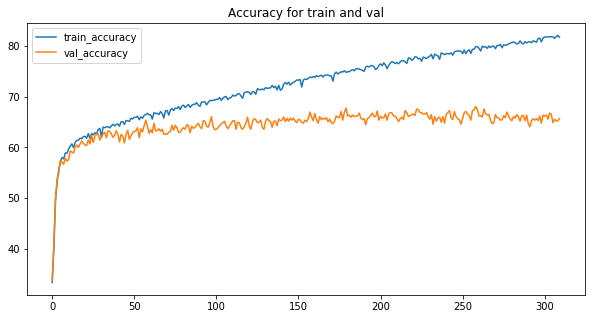

In [91]:
print('hidden_size_con = 100\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=100, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0, save = False)

hidden_size_con = 150
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 45.477, Validation Acc: 44.8
Epoch: [1/10], Step: [201/3125], Train Acc: 46.28, Validation Acc: 46.1
Epoch: [1/10], Step: [301/3125], Train Acc: 50.625, Validation Acc: 51.1
Epoch: [1/10], Step: [401/3125], Train Acc: 55.167, Validation Acc: 55.3
Epoch: [1/10], Step: [501/3125], Train Acc: 56.502, Validation Acc: 56.6
Epoch: [1/10], Step: [601/3125], Train Acc: 57.232, Validation Acc: 57.3
Epoch: [1/10], Step: [701/3125], Train Acc: 58.513, Validation Acc: 58.3
Epoch: [1/10], Step: [801/3125], Train Acc: 59.143, Validation Acc: 58.9
Epoch: [1/10], Step: [901/3125], Train Acc: 59.831, Validation Acc: 59.2
Epoch: [1/10], Step: [1001/3125], Train Acc: 57.287, Validation Acc: 57.0
Epoch: [1/10], Step: [1101/3125], Train Acc: 60.715, Validation Acc: 59.4
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.137, Validation Acc: 60.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.627, Validation Acc: 60.5
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 73.246, Validation Acc: 67.3
Epoch: [4/10], Step: [2001/3125], Train Acc: 73.627, Validation Acc: 68.7
Epoch: [4/10], Step: [2101/3125], Train Acc: 73.276, Validation Acc: 68.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 73.427, Validation Acc: 66.7
Epoch: [4/10], Step: [2301/3125], Train Acc: 72.983, Validation Acc: 67.1
Epoch: [4/10], Step: [2401/3125], Train Acc: 73.805, Validation Acc: 68.0
Epoch: [4/10], Step: [2501/3125], Train Acc: 72.548, Validation Acc: 67.5
Epoch: [4/10], Step: [2601/3125], Train Acc: 73.127, Validation Acc: 67.0
Epoch: [4/10], Step: [2701/3125], Train Acc: 73.886, Validation Acc: 68.9
Epoch: [4/10], Step: [2801/3125], Train Acc: 74.022, Validation Acc: 68.5
Epoch: [4/10], Step: [2901/3125], Train Acc: 73.57, Validation Acc: 67.8
Epoch: [4/10], Step: [3001/3125], Train Acc: 74.354, Validation Acc: 67.6
Epoch: [4/10], Step: [3101/3125], Train Acc: 74.253, Validation Acc: 68.7
Epoch: [5/10], Step: [101/3125], Train 

Epoch: [8/10], Step: [701/3125], Train Acc: 81.887, Validation Acc: 67.4
Epoch: [8/10], Step: [801/3125], Train Acc: 81.79, Validation Acc: 68.0
Epoch: [8/10], Step: [901/3125], Train Acc: 81.023, Validation Acc: 65.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 81.274, Validation Acc: 67.6
Epoch: [8/10], Step: [1101/3125], Train Acc: 81.754, Validation Acc: 67.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 82.192, Validation Acc: 67.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 82.002, Validation Acc: 67.3
Epoch: [8/10], Step: [1401/3125], Train Acc: 82.359, Validation Acc: 67.1
Epoch: [8/10], Step: [1501/3125], Train Acc: 82.13, Validation Acc: 68.7
Epoch: [8/10], Step: [1601/3125], Train Acc: 81.603, Validation Acc: 66.8
Epoch: [8/10], Step: [1701/3125], Train Acc: 80.664, Validation Acc: 66.3
Epoch: [8/10], Step: [1801/3125], Train Acc: 81.67, Validation Acc: 67.7
Epoch: [8/10], Step: [1901/3125], Train Acc: 82.595, Validation Acc: 67.7
Epoch: [8/10], Step: [2001/3125], Train Acc:

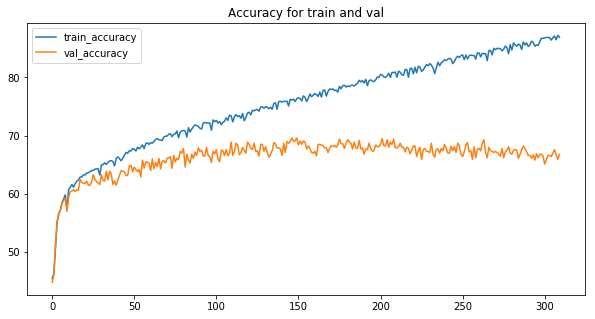

In [92]:
print('hidden_size_con = 150\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0, save = False)

hidden_size_con = 200
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 41.615, Validation Acc: 43.6
Epoch: [1/10], Step: [201/3125], Train Acc: 44.046, Validation Acc: 45.7
Epoch: [1/10], Step: [301/3125], Train Acc: 50.552, Validation Acc: 52.1
Epoch: [1/10], Step: [401/3125], Train Acc: 55.279, Validation Acc: 54.4
Epoch: [1/10], Step: [501/3125], Train Acc: 57.287, Validation Acc: 57.4
Epoch: [1/10], Step: [601/3125], Train Acc: 57.413, Validation Acc: 57.1
Epoch: [1/10], Step: [701/3125], Train Acc: 59.166, Validation Acc: 59.1
Epoch: [1/10], Step: [801/3125], Train Acc: 59.327, Validation Acc: 59.7
Epoch: [1/10], Step: [901/3125], Train Acc: 59.425, Validation Acc: 59.3
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.459, Validation Acc: 59.0
Epoch: [1/10], Step: [1101/3125], Train Acc: 60.395, Validation Acc: 59.4
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.22, Validation Acc: 60.2
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.194, Validation Acc: 60.9
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 74.074, Validation Acc: 66.8
Epoch: [4/10], Step: [2001/3125], Train Acc: 73.203, Validation Acc: 66.0
Epoch: [4/10], Step: [2101/3125], Train Acc: 74.396, Validation Acc: 67.5
Epoch: [4/10], Step: [2201/3125], Train Acc: 73.888, Validation Acc: 66.7
Epoch: [4/10], Step: [2301/3125], Train Acc: 74.381, Validation Acc: 65.7
Epoch: [4/10], Step: [2401/3125], Train Acc: 74.294, Validation Acc: 66.6
Epoch: [4/10], Step: [2501/3125], Train Acc: 74.195, Validation Acc: 66.7
Epoch: [4/10], Step: [2601/3125], Train Acc: 74.738, Validation Acc: 67.7
Epoch: [4/10], Step: [2701/3125], Train Acc: 74.699, Validation Acc: 68.1
Epoch: [4/10], Step: [2801/3125], Train Acc: 73.834, Validation Acc: 64.9
Epoch: [4/10], Step: [2901/3125], Train Acc: 73.579, Validation Acc: 65.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 75.101, Validation Acc: 67.3
Epoch: [4/10], Step: [3101/3125], Train Acc: 75.064, Validation Acc: 66.9
Epoch: [5/10], Step: [101/3125], Train

Epoch: [8/10], Step: [701/3125], Train Acc: 83.605, Validation Acc: 66.6
Epoch: [8/10], Step: [801/3125], Train Acc: 83.494, Validation Acc: 64.4
Epoch: [8/10], Step: [901/3125], Train Acc: 83.283, Validation Acc: 66.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 83.564, Validation Acc: 64.8
Epoch: [8/10], Step: [1101/3125], Train Acc: 83.879, Validation Acc: 66.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 83.796, Validation Acc: 67.5
Epoch: [8/10], Step: [1301/3125], Train Acc: 83.914, Validation Acc: 66.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 81.875, Validation Acc: 67.0
Epoch: [8/10], Step: [1501/3125], Train Acc: 84.159, Validation Acc: 66.8
Epoch: [8/10], Step: [1601/3125], Train Acc: 83.973, Validation Acc: 65.4
Epoch: [8/10], Step: [1701/3125], Train Acc: 83.885, Validation Acc: 66.3
Epoch: [8/10], Step: [1801/3125], Train Acc: 82.147, Validation Acc: 65.0
Epoch: [8/10], Step: [1901/3125], Train Acc: 84.326, Validation Acc: 66.9
Epoch: [8/10], Step: [2001/3125], Train A

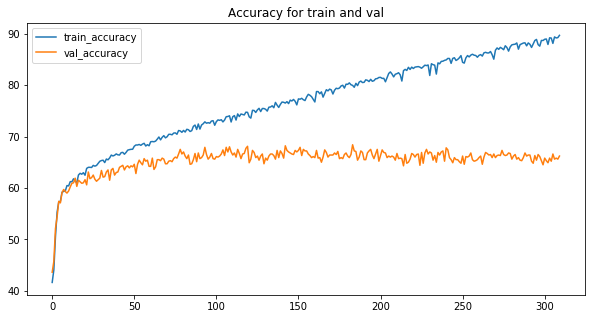

In [93]:
print('hidden_size_con = 200\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=200, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0, save = False)

hidden_size_con = 250
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.778, Validation Acc: 34.6
Epoch: [1/10], Step: [201/3125], Train Acc: 50.086, Validation Acc: 51.1
Epoch: [1/10], Step: [301/3125], Train Acc: 50.754, Validation Acc: 51.2
Epoch: [1/10], Step: [401/3125], Train Acc: 55.858, Validation Acc: 55.8
Epoch: [1/10], Step: [501/3125], Train Acc: 57.713, Validation Acc: 57.7
Epoch: [1/10], Step: [601/3125], Train Acc: 58.531, Validation Acc: 58.8
Epoch: [1/10], Step: [701/3125], Train Acc: 59.6, Validation Acc: 60.1
Epoch: [1/10], Step: [801/3125], Train Acc: 60.156, Validation Acc: 60.2
Epoch: [1/10], Step: [901/3125], Train Acc: 59.327, Validation Acc: 58.9
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.523, Validation Acc: 60.1
Epoch: [1/10], Step: [1101/3125], Train Acc: 58.693, Validation Acc: 57.6
Epoch: [1/10], Step: [1201/3125], Train Acc: 58.957, Validation Acc: 58.2
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.843, Validation Acc: 61.8
Epoch

Epoch: [4/10], Step: [1901/3125], Train Acc: 74.554, Validation Acc: 68.1
Epoch: [4/10], Step: [2001/3125], Train Acc: 74.759, Validation Acc: 67.2
Epoch: [4/10], Step: [2101/3125], Train Acc: 74.808, Validation Acc: 67.0
Epoch: [4/10], Step: [2201/3125], Train Acc: 74.678, Validation Acc: 66.9
Epoch: [4/10], Step: [2301/3125], Train Acc: 74.566, Validation Acc: 66.4
Epoch: [4/10], Step: [2401/3125], Train Acc: 75.146, Validation Acc: 66.9
Epoch: [4/10], Step: [2501/3125], Train Acc: 75.101, Validation Acc: 66.7
Epoch: [4/10], Step: [2601/3125], Train Acc: 74.11, Validation Acc: 66.6
Epoch: [4/10], Step: [2701/3125], Train Acc: 74.873, Validation Acc: 67.1
Epoch: [4/10], Step: [2801/3125], Train Acc: 74.959, Validation Acc: 66.2
Epoch: [4/10], Step: [2901/3125], Train Acc: 75.13, Validation Acc: 66.7
Epoch: [4/10], Step: [3001/3125], Train Acc: 74.562, Validation Acc: 65.5
Epoch: [4/10], Step: [3101/3125], Train Acc: 75.357, Validation Acc: 65.9
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 82.686, Validation Acc: 65.3
Epoch: [8/10], Step: [801/3125], Train Acc: 84.649, Validation Acc: 66.7
Epoch: [8/10], Step: [901/3125], Train Acc: 84.843, Validation Acc: 66.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 84.12, Validation Acc: 66.6
Epoch: [8/10], Step: [1101/3125], Train Acc: 83.847, Validation Acc: 66.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 84.747, Validation Acc: 65.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 85.253, Validation Acc: 65.2
Epoch: [8/10], Step: [1401/3125], Train Acc: 84.285, Validation Acc: 65.6
Epoch: [8/10], Step: [1501/3125], Train Acc: 85.402, Validation Acc: 65.8
Epoch: [8/10], Step: [1601/3125], Train Acc: 85.004, Validation Acc: 65.5
Epoch: [8/10], Step: [1701/3125], Train Acc: 84.886, Validation Acc: 65.1
Epoch: [8/10], Step: [1801/3125], Train Acc: 85.479, Validation Acc: 66.4
Epoch: [8/10], Step: [1901/3125], Train Acc: 85.593, Validation Acc: 66.3
Epoch: [8/10], Step: [2001/3125], Train Ac

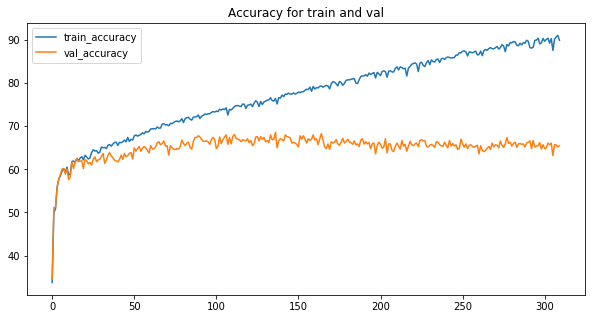

In [94]:
print('hidden_size_con = 250\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=250, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save = False)

hidden_size_con = 300
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.635, Validation Acc: 33.1
Epoch: [1/10], Step: [201/3125], Train Acc: 43.061, Validation Acc: 40.5
Epoch: [1/10], Step: [301/3125], Train Acc: 54.659, Validation Acc: 54.1
Epoch: [1/10], Step: [401/3125], Train Acc: 55.856, Validation Acc: 56.2
Epoch: [1/10], Step: [501/3125], Train Acc: 58.229, Validation Acc: 58.3
Epoch: [1/10], Step: [601/3125], Train Acc: 58.981, Validation Acc: 58.3
Epoch: [1/10], Step: [701/3125], Train Acc: 60.022, Validation Acc: 59.1
Epoch: [1/10], Step: [801/3125], Train Acc: 60.315, Validation Acc: 60.0
Epoch: [1/10], Step: [901/3125], Train Acc: 61.049, Validation Acc: 59.4
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.163, Validation Acc: 59.5
Epoch: [1/10], Step: [1101/3125], Train Acc: 61.334, Validation Acc: 59.7
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.951, Validation Acc: 60.8
Epoch: [1/10], Step: [1301/3125], Train Acc: 62.012, Validation Acc: 61.3
Epo

Epoch: [4/10], Step: [1901/3125], Train Acc: 74.638, Validation Acc: 67.1
Epoch: [4/10], Step: [2001/3125], Train Acc: 74.721, Validation Acc: 65.4
Epoch: [4/10], Step: [2101/3125], Train Acc: 75.436, Validation Acc: 67.8
Epoch: [4/10], Step: [2201/3125], Train Acc: 74.956, Validation Acc: 67.5
Epoch: [4/10], Step: [2301/3125], Train Acc: 75.587, Validation Acc: 66.9
Epoch: [4/10], Step: [2401/3125], Train Acc: 75.323, Validation Acc: 65.8
Epoch: [4/10], Step: [2501/3125], Train Acc: 76.215, Validation Acc: 66.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 75.825, Validation Acc: 66.2
Epoch: [4/10], Step: [2701/3125], Train Acc: 75.099, Validation Acc: 65.0
Epoch: [4/10], Step: [2801/3125], Train Acc: 75.778, Validation Acc: 66.9
Epoch: [4/10], Step: [2901/3125], Train Acc: 76.281, Validation Acc: 66.2
Epoch: [4/10], Step: [3001/3125], Train Acc: 76.358, Validation Acc: 65.6
Epoch: [4/10], Step: [3101/3125], Train Acc: 75.941, Validation Acc: 66.3
Epoch: [5/10], Step: [101/3125], Train

Epoch: [8/10], Step: [701/3125], Train Acc: 86.959, Validation Acc: 65.7
Epoch: [8/10], Step: [801/3125], Train Acc: 86.24, Validation Acc: 66.8
Epoch: [8/10], Step: [901/3125], Train Acc: 86.677, Validation Acc: 65.7
Epoch: [8/10], Step: [1001/3125], Train Acc: 86.776, Validation Acc: 66.3
Epoch: [8/10], Step: [1101/3125], Train Acc: 86.964, Validation Acc: 66.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 86.764, Validation Acc: 65.8
Epoch: [8/10], Step: [1301/3125], Train Acc: 86.548, Validation Acc: 65.2
Epoch: [8/10], Step: [1401/3125], Train Acc: 87.483, Validation Acc: 65.1
Epoch: [8/10], Step: [1501/3125], Train Acc: 86.797, Validation Acc: 66.3
Epoch: [8/10], Step: [1601/3125], Train Acc: 87.619, Validation Acc: 65.5
Epoch: [8/10], Step: [1701/3125], Train Acc: 86.302, Validation Acc: 65.1
Epoch: [8/10], Step: [1801/3125], Train Acc: 86.121, Validation Acc: 66.3
Epoch: [8/10], Step: [1901/3125], Train Acc: 86.997, Validation Acc: 65.4
Epoch: [8/10], Step: [2001/3125], Train Ac

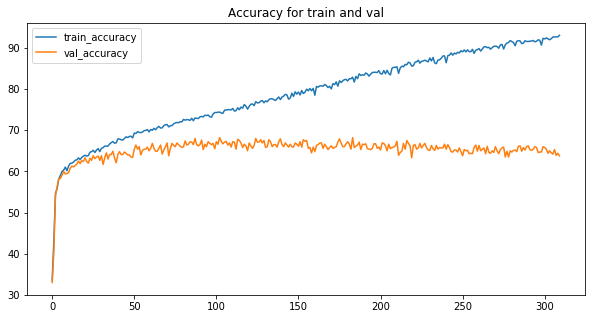

In [95]:
print('hidden_size_con = 300\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=300, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save = False)

### Hidden_size for CNN = 150

### Tuning over kernel size [3,5,7]

Kernel Size = 3
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 34.723, Validation Acc: 35.8
Epoch: [1/10], Step: [201/3125], Train Acc: 52.406, Validation Acc: 53.0
Epoch: [1/10], Step: [301/3125], Train Acc: 54.872, Validation Acc: 55.3
Epoch: [1/10], Step: [401/3125], Train Acc: 56.477, Validation Acc: 56.6
Epoch: [1/10], Step: [501/3125], Train Acc: 58.337, Validation Acc: 58.8
Epoch: [1/10], Step: [601/3125], Train Acc: 58.896, Validation Acc: 59.3
Epoch: [1/10], Step: [701/3125], Train Acc: 58.738, Validation Acc: 57.2
Epoch: [1/10], Step: [801/3125], Train Acc: 59.743, Validation Acc: 59.0
Epoch: [1/10], Step: [901/3125], Train Acc: 57.474, Validation Acc: 56.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.707, Validation Acc: 60.8
Epoch: [1/10], Step: [1101/3125], Train Acc: 60.196, Validation Acc: 60.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.357, Validation Acc: 60.1
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.883, Validation Acc: 61.2
Epoch: [1

Epoch: [4/10], Step: [1901/3125], Train Acc: 72.665, Validation Acc: 66.9
Epoch: [4/10], Step: [2001/3125], Train Acc: 73.052, Validation Acc: 66.8
Epoch: [4/10], Step: [2101/3125], Train Acc: 73.3, Validation Acc: 67.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 73.88, Validation Acc: 67.1
Epoch: [4/10], Step: [2301/3125], Train Acc: 73.822, Validation Acc: 66.8
Epoch: [4/10], Step: [2401/3125], Train Acc: 73.573, Validation Acc: 65.5
Epoch: [4/10], Step: [2501/3125], Train Acc: 73.919, Validation Acc: 67.0
Epoch: [4/10], Step: [2601/3125], Train Acc: 73.969, Validation Acc: 66.9
Epoch: [4/10], Step: [2701/3125], Train Acc: 74.092, Validation Acc: 67.4
Epoch: [4/10], Step: [2801/3125], Train Acc: 74.401, Validation Acc: 67.6
Epoch: [4/10], Step: [2901/3125], Train Acc: 74.485, Validation Acc: 65.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 74.458, Validation Acc: 67.5
Epoch: [4/10], Step: [3101/3125], Train Acc: 74.31, Validation Acc: 67.6
Epoch: [5/10], Step: [101/3125], Train Acc

Epoch: [8/10], Step: [701/3125], Train Acc: 82.094, Validation Acc: 65.8
Epoch: [8/10], Step: [801/3125], Train Acc: 80.691, Validation Acc: 65.5
Epoch: [8/10], Step: [901/3125], Train Acc: 82.322, Validation Acc: 65.8
Epoch: [8/10], Step: [1001/3125], Train Acc: 82.434, Validation Acc: 65.3
Epoch: [8/10], Step: [1101/3125], Train Acc: 82.202, Validation Acc: 65.5
Epoch: [8/10], Step: [1201/3125], Train Acc: 82.455, Validation Acc: 67.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 82.471, Validation Acc: 66.9
Epoch: [8/10], Step: [1401/3125], Train Acc: 81.706, Validation Acc: 66.6
Epoch: [8/10], Step: [1501/3125], Train Acc: 82.727, Validation Acc: 67.6
Epoch: [8/10], Step: [1601/3125], Train Acc: 82.422, Validation Acc: 67.1
Epoch: [8/10], Step: [1701/3125], Train Acc: 80.321, Validation Acc: 65.9
Epoch: [8/10], Step: [1801/3125], Train Acc: 82.46, Validation Acc: 66.8
Epoch: [8/10], Step: [1901/3125], Train Acc: 82.926, Validation Acc: 67.0
Epoch: [8/10], Step: [2001/3125], Train Ac

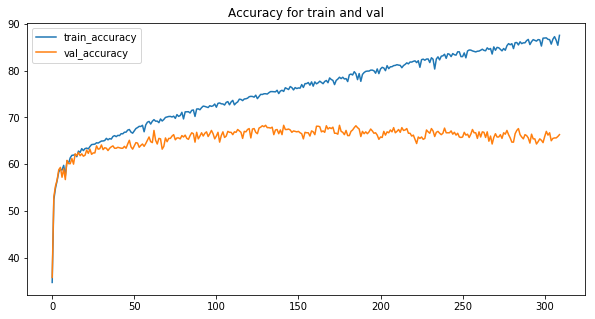

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [55]:
print('Kernel Size = 3\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save = True)

Kernel Size = 5
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 45.884, Validation Acc: 47.4
Epoch: [1/10], Step: [201/3125], Train Acc: 51.733, Validation Acc: 49.9
Epoch: [1/10], Step: [301/3125], Train Acc: 55.746, Validation Acc: 56.4
Epoch: [1/10], Step: [401/3125], Train Acc: 57.532, Validation Acc: 57.9
Epoch: [1/10], Step: [501/3125], Train Acc: 58.66, Validation Acc: 59.5
Epoch: [1/10], Step: [601/3125], Train Acc: 58.175, Validation Acc: 57.6
Epoch: [1/10], Step: [701/3125], Train Acc: 59.136, Validation Acc: 59.3
Epoch: [1/10], Step: [801/3125], Train Acc: 58.275, Validation Acc: 58.2
Epoch: [1/10], Step: [901/3125], Train Acc: 60.332, Validation Acc: 60.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.724, Validation Acc: 59.9
Epoch: [1/10], Step: [1101/3125], Train Acc: 61.145, Validation Acc: 59.3
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.543, Validation Acc: 60.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.997, Validation Acc: 59.7
Epoch: [1/

Epoch: [4/10], Step: [1901/3125], Train Acc: 75.984, Validation Acc: 67.0
Epoch: [4/10], Step: [2001/3125], Train Acc: 76.245, Validation Acc: 66.7
Epoch: [4/10], Step: [2101/3125], Train Acc: 76.109, Validation Acc: 66.7
Epoch: [4/10], Step: [2201/3125], Train Acc: 76.565, Validation Acc: 66.7
Epoch: [4/10], Step: [2301/3125], Train Acc: 76.934, Validation Acc: 67.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 76.491, Validation Acc: 67.6
Epoch: [4/10], Step: [2501/3125], Train Acc: 76.382, Validation Acc: 67.8
Epoch: [4/10], Step: [2601/3125], Train Acc: 76.814, Validation Acc: 65.8
Epoch: [4/10], Step: [2701/3125], Train Acc: 76.898, Validation Acc: 66.8
Epoch: [4/10], Step: [2801/3125], Train Acc: 76.704, Validation Acc: 67.5
Epoch: [4/10], Step: [2901/3125], Train Acc: 76.369, Validation Acc: 67.3
Epoch: [4/10], Step: [3001/3125], Train Acc: 76.658, Validation Acc: 68.6
Epoch: [4/10], Step: [3101/3125], Train Acc: 77.555, Validation Acc: 67.9
Epoch: [5/10], Step: [101/3125], Train

Epoch: [8/10], Step: [701/3125], Train Acc: 88.166, Validation Acc: 66.2
Epoch: [8/10], Step: [801/3125], Train Acc: 87.343, Validation Acc: 65.1
Epoch: [8/10], Step: [901/3125], Train Acc: 86.288, Validation Acc: 63.3
Epoch: [8/10], Step: [1001/3125], Train Acc: 88.231, Validation Acc: 64.9
Epoch: [8/10], Step: [1101/3125], Train Acc: 88.51, Validation Acc: 65.1
Epoch: [8/10], Step: [1201/3125], Train Acc: 86.646, Validation Acc: 62.2
Epoch: [8/10], Step: [1301/3125], Train Acc: 88.101, Validation Acc: 64.8
Epoch: [8/10], Step: [1401/3125], Train Acc: 88.089, Validation Acc: 64.5
Epoch: [8/10], Step: [1501/3125], Train Acc: 88.479, Validation Acc: 63.9
Epoch: [8/10], Step: [1601/3125], Train Acc: 88.601, Validation Acc: 63.9
Epoch: [8/10], Step: [1701/3125], Train Acc: 87.778, Validation Acc: 62.4
Epoch: [8/10], Step: [1801/3125], Train Acc: 88.413, Validation Acc: 63.8
Epoch: [8/10], Step: [1901/3125], Train Acc: 88.546, Validation Acc: 65.0
Epoch: [8/10], Step: [2001/3125], Train Ac

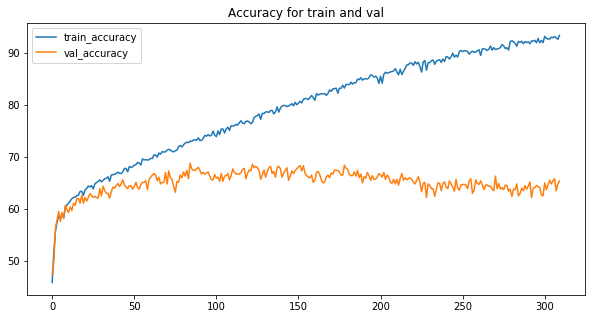

In [56]:
print('Kernel Size = 5\n---------------------')
model = CNN(emb_size=300, ksize=5, psize =2, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save = False)

Kernel Size = 7
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 43.753, Validation Acc: 42.3
Epoch: [1/10], Step: [201/3125], Train Acc: 51.113, Validation Acc: 49.8
Epoch: [1/10], Step: [301/3125], Train Acc: 55.581, Validation Acc: 54.6
Epoch: [1/10], Step: [401/3125], Train Acc: 57.018, Validation Acc: 57.4
Epoch: [1/10], Step: [501/3125], Train Acc: 58.674, Validation Acc: 59.4
Epoch: [1/10], Step: [601/3125], Train Acc: 58.68, Validation Acc: 57.5
Epoch: [1/10], Step: [701/3125], Train Acc: 59.139, Validation Acc: 58.0
Epoch: [1/10], Step: [801/3125], Train Acc: 60.203, Validation Acc: 59.5
Epoch: [1/10], Step: [901/3125], Train Acc: 60.274, Validation Acc: 59.8
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.986, Validation Acc: 60.5
Epoch: [1/10], Step: [1101/3125], Train Acc: 60.685, Validation Acc: 59.5
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.661, Validation Acc: 59.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 61.591, Validation Acc: 61.0
Epoch: [1/

Epoch: [4/10], Step: [1901/3125], Train Acc: 77.001, Validation Acc: 64.9
Epoch: [4/10], Step: [2001/3125], Train Acc: 76.405, Validation Acc: 65.8
Epoch: [4/10], Step: [2101/3125], Train Acc: 77.196, Validation Acc: 66.2
Epoch: [4/10], Step: [2201/3125], Train Acc: 77.394, Validation Acc: 67.8
Epoch: [4/10], Step: [2301/3125], Train Acc: 77.449, Validation Acc: 66.4
Epoch: [4/10], Step: [2401/3125], Train Acc: 78.111, Validation Acc: 66.9
Epoch: [4/10], Step: [2501/3125], Train Acc: 78.013, Validation Acc: 65.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 77.629, Validation Acc: 66.4
Epoch: [4/10], Step: [2701/3125], Train Acc: 77.976, Validation Acc: 66.4
Epoch: [4/10], Step: [2801/3125], Train Acc: 78.274, Validation Acc: 66.3
Epoch: [4/10], Step: [2901/3125], Train Acc: 78.272, Validation Acc: 67.7
Epoch: [4/10], Step: [3001/3125], Train Acc: 78.55, Validation Acc: 66.9
Epoch: [4/10], Step: [3101/3125], Train Acc: 78.145, Validation Acc: 66.3
Epoch: [5/10], Step: [101/3125], Train 

Epoch: [8/10], Step: [701/3125], Train Acc: 90.465, Validation Acc: 65.5
Epoch: [8/10], Step: [801/3125], Train Acc: 90.845, Validation Acc: 64.5
Epoch: [8/10], Step: [901/3125], Train Acc: 90.315, Validation Acc: 62.4
Epoch: [8/10], Step: [1001/3125], Train Acc: 90.856, Validation Acc: 64.7
Epoch: [8/10], Step: [1101/3125], Train Acc: 87.777, Validation Acc: 63.1
Epoch: [8/10], Step: [1201/3125], Train Acc: 90.36, Validation Acc: 65.6
Epoch: [8/10], Step: [1301/3125], Train Acc: 91.118, Validation Acc: 66.5
Epoch: [8/10], Step: [1401/3125], Train Acc: 91.026, Validation Acc: 66.2
Epoch: [8/10], Step: [1501/3125], Train Acc: 91.178, Validation Acc: 66.0
Epoch: [8/10], Step: [1601/3125], Train Acc: 91.067, Validation Acc: 64.9
Epoch: [8/10], Step: [1701/3125], Train Acc: 90.847, Validation Acc: 63.7
Epoch: [8/10], Step: [1801/3125], Train Acc: 91.151, Validation Acc: 64.2
Epoch: [8/10], Step: [1901/3125], Train Acc: 90.244, Validation Acc: 64.5
Epoch: [8/10], Step: [2001/3125], Train Ac

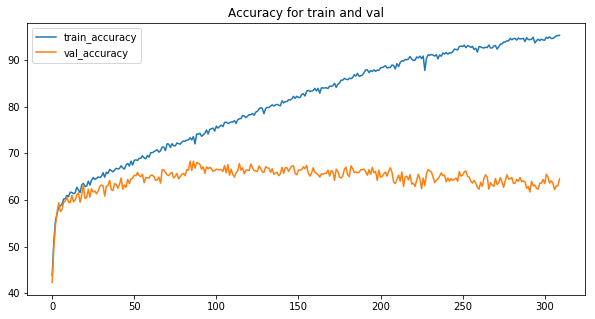

In [60]:
print('Kernel Size = 7\n---------------------')
model = CNN(emb_size=300, ksize=7, psize =3, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save = False)

Weight Decay = 0.0001
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 35.858, Validation Acc: 35.5
Epoch: [1/10], Step: [201/3125], Train Acc: 48.979, Validation Acc: 49.7
Epoch: [1/10], Step: [301/3125], Train Acc: 53.173, Validation Acc: 53.8
Epoch: [1/10], Step: [401/3125], Train Acc: 56.502, Validation Acc: 56.6
Epoch: [1/10], Step: [501/3125], Train Acc: 57.757, Validation Acc: 59.0
Epoch: [1/10], Step: [601/3125], Train Acc: 58.627, Validation Acc: 58.9
Epoch: [1/10], Step: [701/3125], Train Acc: 59.12, Validation Acc: 60.7
Epoch: [1/10], Step: [801/3125], Train Acc: 59.708, Validation Acc: 60.9
Epoch: [1/10], Step: [901/3125], Train Acc: 59.765, Validation Acc: 59.4
Epoch: [1/10], Step: [1001/3125], Train Acc: 60.342, Validation Acc: 59.7
Epoch: [1/10], Step: [1101/3125], Train Acc: 60.903, Validation Acc: 61.8
Epoch: [1/10], Step: [1201/3125], Train Acc: 61.644, Validation Acc: 61.7
Epoch: [1/10], Step: [1301/3125], Train Acc: 60.917, Validation Acc: 60.7
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 72.934, Validation Acc: 66.2
Epoch: [4/10], Step: [2001/3125], Train Acc: 72.36, Validation Acc: 66.8
Epoch: [4/10], Step: [2101/3125], Train Acc: 72.381, Validation Acc: 66.7
Epoch: [4/10], Step: [2201/3125], Train Acc: 73.431, Validation Acc: 67.4
Epoch: [4/10], Step: [2301/3125], Train Acc: 72.472, Validation Acc: 66.1
Epoch: [4/10], Step: [2401/3125], Train Acc: 72.446, Validation Acc: 66.5
Epoch: [4/10], Step: [2501/3125], Train Acc: 73.357, Validation Acc: 67.1
Epoch: [4/10], Step: [2601/3125], Train Acc: 73.369, Validation Acc: 66.1
Epoch: [4/10], Step: [2701/3125], Train Acc: 73.448, Validation Acc: 66.3
Epoch: [4/10], Step: [2801/3125], Train Acc: 73.399, Validation Acc: 66.6
Epoch: [4/10], Step: [2901/3125], Train Acc: 73.297, Validation Acc: 66.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 73.61, Validation Acc: 66.9
Epoch: [4/10], Step: [3101/3125], Train Acc: 73.662, Validation Acc: 65.4
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 80.273, Validation Acc: 66.4
Epoch: [8/10], Step: [801/3125], Train Acc: 80.012, Validation Acc: 66.6
Epoch: [8/10], Step: [901/3125], Train Acc: 80.492, Validation Acc: 66.8
Epoch: [8/10], Step: [1001/3125], Train Acc: 78.848, Validation Acc: 64.7
Epoch: [8/10], Step: [1101/3125], Train Acc: 79.445, Validation Acc: 66.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 80.506, Validation Acc: 66.9
Epoch: [8/10], Step: [1301/3125], Train Acc: 80.412, Validation Acc: 66.0
Epoch: [8/10], Step: [1401/3125], Train Acc: 80.764, Validation Acc: 66.9
Epoch: [8/10], Step: [1501/3125], Train Acc: 81.254, Validation Acc: 66.3
Epoch: [8/10], Step: [1601/3125], Train Acc: 80.839, Validation Acc: 66.3
Epoch: [8/10], Step: [1701/3125], Train Acc: 80.525, Validation Acc: 65.5
Epoch: [8/10], Step: [1801/3125], Train Acc: 80.551, Validation Acc: 67.4
Epoch: [8/10], Step: [1901/3125], Train Acc: 81.501, Validation Acc: 67.2
Epoch: [8/10], Step: [2001/3125], Train A

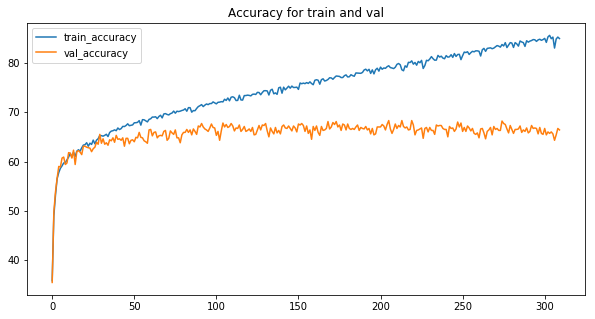

In [61]:
print('Weight Decay = 0.0001\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0.0001,save = False)

Weight Decay = 0.0005
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.217, Validation Acc: 33.8
Epoch: [1/10], Step: [201/3125], Train Acc: 41.689, Validation Acc: 42.4
Epoch: [1/10], Step: [301/3125], Train Acc: 49.202, Validation Acc: 46.8
Epoch: [1/10], Step: [401/3125], Train Acc: 55.272, Validation Acc: 55.1
Epoch: [1/10], Step: [501/3125], Train Acc: 56.478, Validation Acc: 55.8
Epoch: [1/10], Step: [601/3125], Train Acc: 57.182, Validation Acc: 56.7
Epoch: [1/10], Step: [701/3125], Train Acc: 57.563, Validation Acc: 56.1
Epoch: [1/10], Step: [801/3125], Train Acc: 58.762, Validation Acc: 58.9
Epoch: [1/10], Step: [901/3125], Train Acc: 59.157, Validation Acc: 59.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 59.569, Validation Acc: 59.7
Epoch: [1/10], Step: [1101/3125], Train Acc: 59.866, Validation Acc: 60.8
Epoch: [1/10], Step: [1201/3125], Train Acc: 60.077, Validation Acc: 60.8
Epoch: [1/10], Step: [1301/3125], Train Acc: 60.122, Validation Acc: 59.7
Epo

Epoch: [4/10], Step: [1901/3125], Train Acc: 68.284, Validation Acc: 63.5
Epoch: [4/10], Step: [2001/3125], Train Acc: 68.331, Validation Acc: 64.2
Epoch: [4/10], Step: [2101/3125], Train Acc: 66.932, Validation Acc: 61.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.32, Validation Acc: 64.8
Epoch: [4/10], Step: [2301/3125], Train Acc: 68.486, Validation Acc: 64.2
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.534, Validation Acc: 63.3
Epoch: [4/10], Step: [2501/3125], Train Acc: 67.822, Validation Acc: 64.0
Epoch: [4/10], Step: [2601/3125], Train Acc: 68.276, Validation Acc: 63.7
Epoch: [4/10], Step: [2701/3125], Train Acc: 67.818, Validation Acc: 63.2
Epoch: [4/10], Step: [2801/3125], Train Acc: 68.775, Validation Acc: 63.9
Epoch: [4/10], Step: [2901/3125], Train Acc: 68.194, Validation Acc: 63.7
Epoch: [4/10], Step: [3001/3125], Train Acc: 68.784, Validation Acc: 64.4
Epoch: [4/10], Step: [3101/3125], Train Acc: 68.985, Validation Acc: 63.9
Epoch: [5/10], Step: [101/3125], Train 

Epoch: [8/10], Step: [701/3125], Train Acc: 70.875, Validation Acc: 62.6
Epoch: [8/10], Step: [801/3125], Train Acc: 73.352, Validation Acc: 66.9
Epoch: [8/10], Step: [901/3125], Train Acc: 73.204, Validation Acc: 66.2
Epoch: [8/10], Step: [1001/3125], Train Acc: 72.655, Validation Acc: 63.8
Epoch: [8/10], Step: [1101/3125], Train Acc: 73.292, Validation Acc: 64.6
Epoch: [8/10], Step: [1201/3125], Train Acc: 73.675, Validation Acc: 64.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 73.294, Validation Acc: 64.8
Epoch: [8/10], Step: [1401/3125], Train Acc: 73.529, Validation Acc: 64.8
Epoch: [8/10], Step: [1501/3125], Train Acc: 73.954, Validation Acc: 64.4
Epoch: [8/10], Step: [1601/3125], Train Acc: 73.854, Validation Acc: 65.3
Epoch: [8/10], Step: [1701/3125], Train Acc: 73.971, Validation Acc: 65.0
Epoch: [8/10], Step: [1801/3125], Train Acc: 73.876, Validation Acc: 65.3
Epoch: [8/10], Step: [1901/3125], Train Acc: 73.442, Validation Acc: 66.3
Epoch: [8/10], Step: [2001/3125], Train A

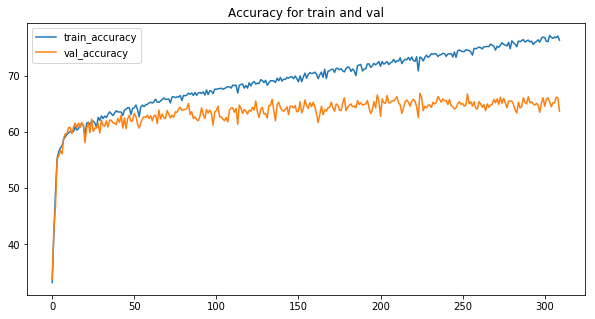

In [62]:
print('Weight Decay = 0.0005\n---------------------')
model = CNN(emb_size=300, ksize=3, psize =1, hidden_size_con=150, hidden_size_ln=50,
            num_layers=2, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0.0005, save = False)

### Model - RNN
#### single-layer, bi-directional GRU will suffice


In [34]:
# Reference on sorting & unsorting:
# https://github.com/facebookresearch/DrQA/blob/master/drqa/reader/layers.py#L103-L165
weight = torch.from_numpy(emb_vec)
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, hidden_size_ln, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size, self.hidden_size_ln = num_layers, hidden_size, hidden_size_ln
        self.embedding = nn.Embedding.from_pretrained(weight.float())
        
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.gru = self.gru.to(device)
        self.linear1 = nn.Linear(4*hidden_size, hidden_size_ln)
        self.linear2 = nn.Linear(hidden_size_ln, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden.to(device)

    def forward(self, s1, lens1, s2, lens2):
        # reset hidden state
        #pdb.set_trace()
        batch_size, seq_len_1 = s1.size()
        batch_size, seq_len_2 = s2.size()
        
        """Slower (significantly), but more precise, encoding that handles
        padding.
        """
        #lengths = x_mask.data.eq(0).long().sum(1).squeeze()
        #_, idx_sort = torch.sort(lengths, dim=0, descending=True)
        #_, idx_unsort = torch.sort(idx_sort, dim=0)
        # Compute sorted sequence lengths
        
        sorted_s1, sorted_indices_s1 = torch.sort(lens1,dim=0,descending=True)
        sorted_s2, sorted_indices_s2 = torch.sort(lens2,dim=0,descending=True)
        
        _, idx_unsort_s1 = torch.sort(sorted_indices_s1, dim=0)
        _, idx_unsort_s2 = torch.sort(sorted_indices_s2, dim=0)
        
        #pdb.set_trace()
#         print(sorted_indices_s1)
#         print('---')
#         print(idx_unsort_s1)
        #print(sorted_indices_s1)
        
        self.hidden_1 = self.init_hidden(batch_size)
        self.hidden_2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed_1 = self.embedding(s1)
        embed_2 = self.embedding(s2)
        #pdb.set_trace()

        embed_1 = torch.index_select(embed_1, 0, sorted_indices_s1)
        embed_2 = torch.index_select(embed_2, 0, sorted_indices_s2)
        lens1 = torch.index_select(lens1, 0, sorted_indices_s1)
        lens2 = torch.index_select(lens2, 0, sorted_indices_s2)
        #print(embed_1.shape,embed_1)
        
        # pack padded sequence
        embed_1 = torch.nn.utils.rnn.pack_padded_sequence(embed_1, lens1, batch_first=True)
        embed_2 = torch.nn.utils.rnn.pack_padded_sequence(embed_2, lens2, batch_first=True)
        #print(embed_1)
        #pdb.set_trace()
        # fprop though RNN
        rnn_out_1, self.hidden_1 = self.gru(embed_1, self.hidden_1)
        rnn_out_2, self.hidden_2 = self.gru(embed_2, self.hidden_2)
        #pdb.set_trace()
        #print(rnn_out_1)
        
        # undo packing
        #print(rnn_out_1)
        self.hidden_1 = self.hidden_1.transpose(0,1)
        self.hidden_1 = self.hidden_1.contiguous().view(batch_size,-1)
        
        self.hidden_2 = self.hidden_2.transpose(0,1)
        self.hidden_2 = self.hidden_2.contiguous().view(batch_size,-1)
        
        # undo packing
#         rnn_out_1, hidden_1 = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_1, batch_first=True)
#         rnn_out_2, hidden_2 = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_2, batch_first=True)
        #print(hidden_1.shape)
        
        
        #print(rnn_out_1.shape)
        hidden_1 = self.hidden_1.index_select(0, idx_unsort_s1)
        hidden_2 = self.hidden_2.index_select(0, idx_unsort_s2)
        
        hidden = torch.cat((hidden_1, hidden_2), dim=1)

        logits = self.linear1(hidden)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        
        return logits.to(device)



In [35]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    model.eval()
    for s1, lens1, s2, lens2, labels in loader:
        
        data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2,label_batch = s1.to(device), lens1.to(device), \
        s2.to(device), lens2.to(device), labels.to(device)
        outputs1 = model(data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2)
#         loss = criterion(outputs1, labels)
#         loss = loss.item() * len(data_batch_1) / len(loader.dataset)
        #outputs = F.softmax(model(data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2), dim=1)
        
        outputs = F.softmax(outputs1,dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model,lr,nepochs,decay,save):
    model = model.to(device)
    learning_rate = lr
    num_epochs = nepochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay)

    # Train the model
    total_step = len(train_loader)

    val_acclst = []
    #val_losslst = []
    train_acclst = []
    #train_losslst = []
    train_acc = 0
    val_acc = 0

    for epoch in range(num_epochs):
        for i, (s1, lens1, s2, lens2, labels) in enumerate(train_loader):
            
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(s1.to(device), lens1.to(device), s2.to(device), lens2.to(device))
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            loss.backward()
            optimizer.step()
            #if i % 10 ==0: print(float((outputs.max(1)[1]).eq(labels).sum())/32)
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
#                 validate
                #train_acc, train_loss = test_model(train_loader, model)
                train_acc = test_model(train_loader, model)
                #train_losslst.append(train_loss)
                train_acclst.append(train_acc)

                val_acc = test_model(val_loader, model)
                #val_acc, val_loss = test_model(val_loader, model)
                #val_losslst.append(val_loss)
                val_acclst.append(val_acc)
                #pdb.set_trace()

                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))


    plt.figure(figsize=(10,5))
#     plt.subplot(2,2,1)
#     plt.plot(train_losslst,label='train_losslst')
#     plt.plot(val_losslst,label='val_loss')
#     plt.title('Loss for train and val')
#     plt.legend()

#     plt.subplot(2,2,2)
    plt.plot(train_acclst,label='train_accuracy')
    plt.plot(val_acclst,label='val_accuracy')
    plt.title('Accuracy for train and val')
    plt.legend()
    plt.show()
    if save==True:
        torch.save(model,'BestModel_RNN.pth')
    


### Tuning over hidden_size_con [100,150,200,250,300]

hidden_size_con = 100
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 38.728, Validation Acc: 37.9
Epoch: [1/10], Step: [201/3125], Train Acc: 44.099, Validation Acc: 45.0
Epoch: [1/10], Step: [301/3125], Train Acc: 46.45, Validation Acc: 44.3
Epoch: [1/10], Step: [401/3125], Train Acc: 49.878, Validation Acc: 49.5
Epoch: [1/10], Step: [501/3125], Train Acc: 53.605, Validation Acc: 54.7
Epoch: [1/10], Step: [601/3125], Train Acc: 53.493, Validation Acc: 54.5
Epoch: [1/10], Step: [701/3125], Train Acc: 54.541, Validation Acc: 54.0
Epoch: [1/10], Step: [801/3125], Train Acc: 55.777, Validation Acc: 55.9
Epoch: [1/10], Step: [901/3125], Train Acc: 55.857, Validation Acc: 55.2
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.402, Validation Acc: 56.3
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.069, Validation Acc: 57.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.329, Validation Acc: 58.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.945, Validation Acc: 58.9
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 67.706, Validation Acc: 66.2
Epoch: [4/10], Step: [2001/3125], Train Acc: 68.025, Validation Acc: 65.7
Epoch: [4/10], Step: [2101/3125], Train Acc: 67.939, Validation Acc: 65.9
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.149, Validation Acc: 67.2
Epoch: [4/10], Step: [2301/3125], Train Acc: 68.269, Validation Acc: 66.1
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.465, Validation Acc: 66.3
Epoch: [4/10], Step: [2501/3125], Train Acc: 68.043, Validation Acc: 66.0
Epoch: [4/10], Step: [2601/3125], Train Acc: 68.311, Validation Acc: 66.2
Epoch: [4/10], Step: [2701/3125], Train Acc: 68.578, Validation Acc: 66.9
Epoch: [4/10], Step: [2801/3125], Train Acc: 68.727, Validation Acc: 66.2
Epoch: [4/10], Step: [2901/3125], Train Acc: 68.39, Validation Acc: 67.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 68.68, Validation Acc: 65.9
Epoch: [4/10], Step: [3101/3125], Train Acc: 68.722, Validation Acc: 66.4
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 72.309, Validation Acc: 68.8
Epoch: [8/10], Step: [801/3125], Train Acc: 71.945, Validation Acc: 68.1
Epoch: [8/10], Step: [901/3125], Train Acc: 72.217, Validation Acc: 68.4
Epoch: [8/10], Step: [1001/3125], Train Acc: 72.502, Validation Acc: 68.8
Epoch: [8/10], Step: [1101/3125], Train Acc: 72.149, Validation Acc: 69.4
Epoch: [8/10], Step: [1201/3125], Train Acc: 72.196, Validation Acc: 68.1
Epoch: [8/10], Step: [1301/3125], Train Acc: 72.371, Validation Acc: 69.3
Epoch: [8/10], Step: [1401/3125], Train Acc: 72.484, Validation Acc: 67.9
Epoch: [8/10], Step: [1501/3125], Train Acc: 72.355, Validation Acc: 69.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 72.469, Validation Acc: 68.7
Epoch: [8/10], Step: [1701/3125], Train Acc: 71.941, Validation Acc: 67.8
Epoch: [8/10], Step: [1801/3125], Train Acc: 72.551, Validation Acc: 69.4
Epoch: [8/10], Step: [1901/3125], Train Acc: 72.694, Validation Acc: 69.0
Epoch: [8/10], Step: [2001/3125], Train A

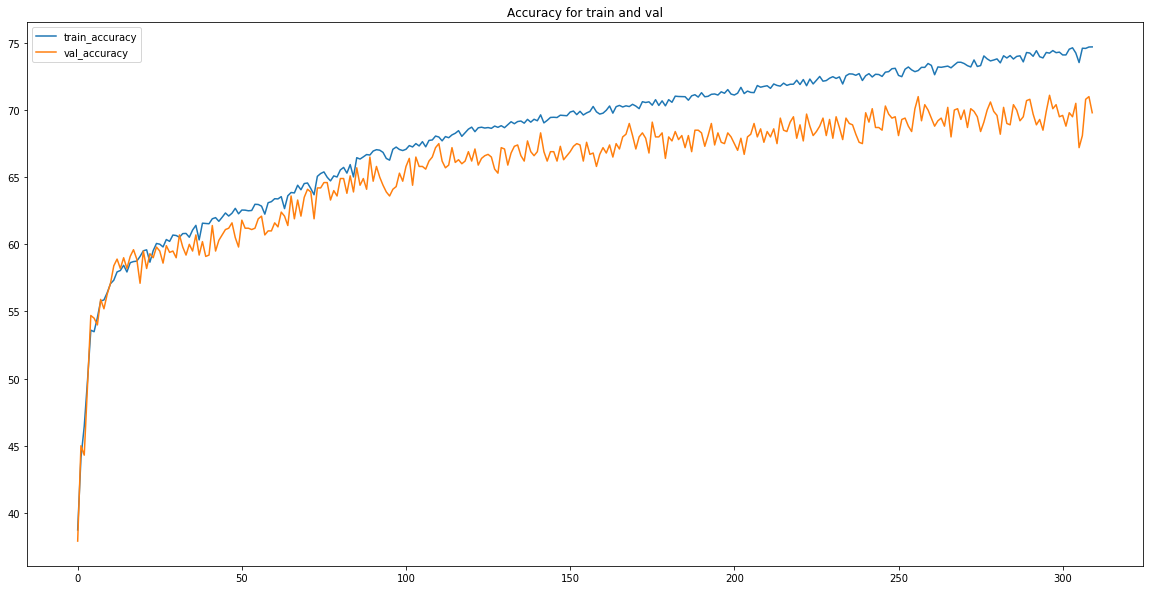

In [98]:
print('hidden_size_con = 100\n---------------------')
model = RNN(emb_size=300,hidden_size=100, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save=False)

hidden_size_con = 150
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 37.234, Validation Acc: 37.4
Epoch: [1/10], Step: [201/3125], Train Acc: 44.692, Validation Acc: 41.9
Epoch: [1/10], Step: [301/3125], Train Acc: 49.219, Validation Acc: 48.7
Epoch: [1/10], Step: [401/3125], Train Acc: 52.267, Validation Acc: 54.3
Epoch: [1/10], Step: [501/3125], Train Acc: 53.531, Validation Acc: 54.7
Epoch: [1/10], Step: [601/3125], Train Acc: 53.154, Validation Acc: 52.1
Epoch: [1/10], Step: [701/3125], Train Acc: 55.299, Validation Acc: 57.4
Epoch: [1/10], Step: [801/3125], Train Acc: 56.135, Validation Acc: 55.9
Epoch: [1/10], Step: [901/3125], Train Acc: 56.038, Validation Acc: 56.0
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.55, Validation Acc: 56.5
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.367, Validation Acc: 57.5
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.525, Validation Acc: 57.8
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.802, Validation Acc: 57.8
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 68.17, Validation Acc: 66.8
Epoch: [4/10], Step: [2001/3125], Train Acc: 68.206, Validation Acc: 67.5
Epoch: [4/10], Step: [2101/3125], Train Acc: 68.22, Validation Acc: 66.9
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.283, Validation Acc: 66.3
Epoch: [4/10], Step: [2301/3125], Train Acc: 68.296, Validation Acc: 65.9
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.637, Validation Acc: 66.5
Epoch: [4/10], Step: [2501/3125], Train Acc: 68.163, Validation Acc: 67.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 68.403, Validation Acc: 65.8
Epoch: [4/10], Step: [2701/3125], Train Acc: 68.476, Validation Acc: 66.2
Epoch: [4/10], Step: [2801/3125], Train Acc: 68.122, Validation Acc: 66.0
Epoch: [4/10], Step: [2901/3125], Train Acc: 68.574, Validation Acc: 66.4
Epoch: [4/10], Step: [3001/3125], Train Acc: 68.354, Validation Acc: 65.8
Epoch: [4/10], Step: [3101/3125], Train Acc: 68.545, Validation Acc: 66.2
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 72.417, Validation Acc: 68.8
Epoch: [8/10], Step: [801/3125], Train Acc: 72.424, Validation Acc: 68.7
Epoch: [8/10], Step: [901/3125], Train Acc: 72.456, Validation Acc: 68.0
Epoch: [8/10], Step: [1001/3125], Train Acc: 72.775, Validation Acc: 69.0
Epoch: [8/10], Step: [1101/3125], Train Acc: 72.515, Validation Acc: 67.3
Epoch: [8/10], Step: [1201/3125], Train Acc: 72.797, Validation Acc: 69.0
Epoch: [8/10], Step: [1301/3125], Train Acc: 72.846, Validation Acc: 68.9
Epoch: [8/10], Step: [1401/3125], Train Acc: 72.899, Validation Acc: 69.6
Epoch: [8/10], Step: [1501/3125], Train Acc: 72.914, Validation Acc: 68.9
Epoch: [8/10], Step: [1601/3125], Train Acc: 73.214, Validation Acc: 68.4
Epoch: [8/10], Step: [1701/3125], Train Acc: 72.942, Validation Acc: 68.5
Epoch: [8/10], Step: [1801/3125], Train Acc: 72.973, Validation Acc: 67.8
Epoch: [8/10], Step: [1901/3125], Train Acc: 73.034, Validation Acc: 69.1
Epoch: [8/10], Step: [2001/3125], Train A

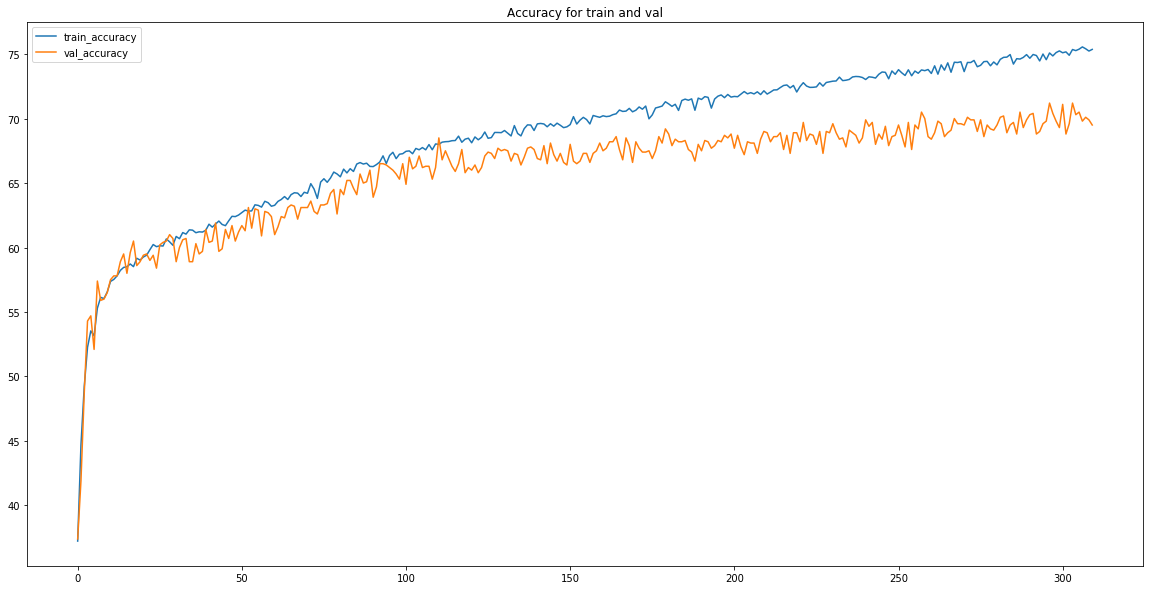

In [99]:
print('hidden_size_con = 150\n---------------------')
model = RNN(emb_size=300,hidden_size=150, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save=False)

hidden_size_con = 200
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 38.085, Validation Acc: 37.6
Epoch: [1/10], Step: [201/3125], Train Acc: 47.601, Validation Acc: 47.5
Epoch: [1/10], Step: [301/3125], Train Acc: 50.726, Validation Acc: 49.8
Epoch: [1/10], Step: [401/3125], Train Acc: 52.853, Validation Acc: 53.8
Epoch: [1/10], Step: [501/3125], Train Acc: 54.265, Validation Acc: 55.3
Epoch: [1/10], Step: [601/3125], Train Acc: 55.445, Validation Acc: 56.0
Epoch: [1/10], Step: [701/3125], Train Acc: 55.877, Validation Acc: 55.5
Epoch: [1/10], Step: [801/3125], Train Acc: 55.703, Validation Acc: 55.2
Epoch: [1/10], Step: [901/3125], Train Acc: 56.6, Validation Acc: 56.3
Epoch: [1/10], Step: [1001/3125], Train Acc: 57.234, Validation Acc: 58.4
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.644, Validation Acc: 58.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 58.097, Validation Acc: 58.6
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.426, Validation Acc: 56.9
Epoch

Epoch: [4/10], Step: [1901/3125], Train Acc: 68.499, Validation Acc: 66.2
Epoch: [4/10], Step: [2001/3125], Train Acc: 68.516, Validation Acc: 64.4
Epoch: [4/10], Step: [2101/3125], Train Acc: 68.575, Validation Acc: 65.1
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.68, Validation Acc: 65.9
Epoch: [4/10], Step: [2301/3125], Train Acc: 68.568, Validation Acc: 64.7
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.988, Validation Acc: 66.4
Epoch: [4/10], Step: [2501/3125], Train Acc: 69.168, Validation Acc: 66.3
Epoch: [4/10], Step: [2601/3125], Train Acc: 69.23, Validation Acc: 66.8
Epoch: [4/10], Step: [2701/3125], Train Acc: 69.058, Validation Acc: 66.2
Epoch: [4/10], Step: [2801/3125], Train Acc: 69.238, Validation Acc: 67.0
Epoch: [4/10], Step: [2901/3125], Train Acc: 68.927, Validation Acc: 65.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 69.283, Validation Acc: 67.1
Epoch: [4/10], Step: [3101/3125], Train Acc: 69.395, Validation Acc: 65.4
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 73.073, Validation Acc: 68.6
Epoch: [8/10], Step: [801/3125], Train Acc: 72.834, Validation Acc: 68.8
Epoch: [8/10], Step: [901/3125], Train Acc: 72.78, Validation Acc: 66.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 72.914, Validation Acc: 68.2
Epoch: [8/10], Step: [1101/3125], Train Acc: 73.168, Validation Acc: 68.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 73.168, Validation Acc: 68.0
Epoch: [8/10], Step: [1301/3125], Train Acc: 73.287, Validation Acc: 68.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 72.814, Validation Acc: 68.0
Epoch: [8/10], Step: [1501/3125], Train Acc: 73.463, Validation Acc: 68.7
Epoch: [8/10], Step: [1601/3125], Train Acc: 73.29, Validation Acc: 67.9
Epoch: [8/10], Step: [1701/3125], Train Acc: 73.006, Validation Acc: 68.5
Epoch: [8/10], Step: [1801/3125], Train Acc: 73.432, Validation Acc: 68.5
Epoch: [8/10], Step: [1901/3125], Train Acc: 73.272, Validation Acc: 68.1
Epoch: [8/10], Step: [2001/3125], Train Acc

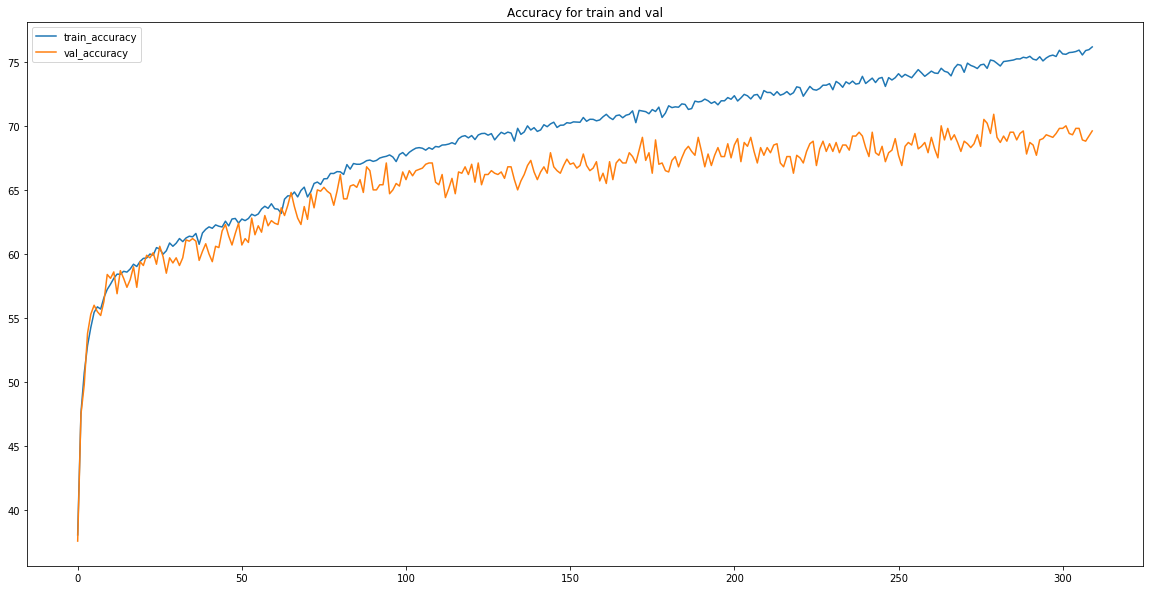

In [100]:
print('hidden_size_con = 200\n---------------------')
model = RNN(emb_size=300,hidden_size=200, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save=False)

hidden_size_con = 250
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 40.743, Validation Acc: 40.0
Epoch: [1/10], Step: [201/3125], Train Acc: 44.649, Validation Acc: 44.3
Epoch: [1/10], Step: [301/3125], Train Acc: 49.637, Validation Acc: 48.6
Epoch: [1/10], Step: [401/3125], Train Acc: 52.969, Validation Acc: 54.5
Epoch: [1/10], Step: [501/3125], Train Acc: 53.945, Validation Acc: 54.5
Epoch: [1/10], Step: [601/3125], Train Acc: 55.246, Validation Acc: 56.7
Epoch: [1/10], Step: [701/3125], Train Acc: 55.57, Validation Acc: 54.9
Epoch: [1/10], Step: [801/3125], Train Acc: 55.199, Validation Acc: 54.1
Epoch: [1/10], Step: [901/3125], Train Acc: 56.189, Validation Acc: 56.7
Epoch: [1/10], Step: [1001/3125], Train Acc: 57.196, Validation Acc: 57.3
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.014, Validation Acc: 57.0
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.517, Validation Acc: 59.0
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.677, Validation Acc: 56.4
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 68.049, Validation Acc: 66.3
Epoch: [4/10], Step: [2001/3125], Train Acc: 69.139, Validation Acc: 66.6
Epoch: [4/10], Step: [2101/3125], Train Acc: 68.71, Validation Acc: 66.0
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.89, Validation Acc: 66.5
Epoch: [4/10], Step: [2301/3125], Train Acc: 69.153, Validation Acc: 66.5
Epoch: [4/10], Step: [2401/3125], Train Acc: 69.028, Validation Acc: 66.4
Epoch: [4/10], Step: [2501/3125], Train Acc: 69.461, Validation Acc: 67.0
Epoch: [4/10], Step: [2601/3125], Train Acc: 69.42, Validation Acc: 67.8
Epoch: [4/10], Step: [2701/3125], Train Acc: 69.315, Validation Acc: 65.9
Epoch: [4/10], Step: [2801/3125], Train Acc: 69.561, Validation Acc: 65.1
Epoch: [4/10], Step: [2901/3125], Train Acc: 69.216, Validation Acc: 65.6
Epoch: [4/10], Step: [3001/3125], Train Acc: 69.752, Validation Acc: 66.9
Epoch: [4/10], Step: [3101/3125], Train Acc: 69.306, Validation Acc: 65.5
Epoch: [5/10], Step: [101/3125], Train Ac

Epoch: [8/10], Step: [701/3125], Train Acc: 74.016, Validation Acc: 69.5
Epoch: [8/10], Step: [801/3125], Train Acc: 74.036, Validation Acc: 68.4
Epoch: [8/10], Step: [901/3125], Train Acc: 73.667, Validation Acc: 68.5
Epoch: [8/10], Step: [1001/3125], Train Acc: 73.731, Validation Acc: 69.1
Epoch: [8/10], Step: [1101/3125], Train Acc: 73.706, Validation Acc: 69.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 73.697, Validation Acc: 69.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 74.091, Validation Acc: 68.7
Epoch: [8/10], Step: [1401/3125], Train Acc: 73.903, Validation Acc: 69.0
Epoch: [8/10], Step: [1501/3125], Train Acc: 74.338, Validation Acc: 69.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 74.027, Validation Acc: 69.3
Epoch: [8/10], Step: [1701/3125], Train Acc: 74.214, Validation Acc: 70.0
Epoch: [8/10], Step: [1801/3125], Train Acc: 74.264, Validation Acc: 68.6
Epoch: [8/10], Step: [1901/3125], Train Acc: 73.975, Validation Acc: 69.3
Epoch: [8/10], Step: [2001/3125], Train A

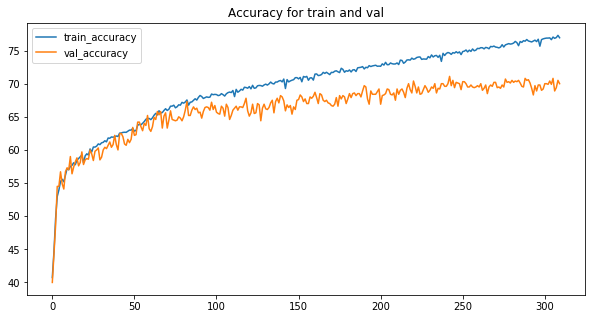

In [31]:
print('hidden_size_con = 250\n---------------------')
model = RNN(emb_size=300,hidden_size=250, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0,save=False)

hidden_size_con = 300
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 42.728, Validation Acc: 41.5
Epoch: [1/10], Step: [201/3125], Train Acc: 47.17, Validation Acc: 46.5
Epoch: [1/10], Step: [301/3125], Train Acc: 50.123, Validation Acc: 49.7
Epoch: [1/10], Step: [401/3125], Train Acc: 51.793, Validation Acc: 50.7
Epoch: [1/10], Step: [501/3125], Train Acc: 53.363, Validation Acc: 51.1
Epoch: [1/10], Step: [601/3125], Train Acc: 54.954, Validation Acc: 55.0
Epoch: [1/10], Step: [701/3125], Train Acc: 55.15, Validation Acc: 56.6
Epoch: [1/10], Step: [801/3125], Train Acc: 56.488, Validation Acc: 57.9
Epoch: [1/10], Step: [901/3125], Train Acc: 56.857, Validation Acc: 57.8
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.521, Validation Acc: 56.4
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.477, Validation Acc: 58.1
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.908, Validation Acc: 57.9
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.024, Validation Acc: 57.6
Epoch

Epoch: [4/10], Step: [1901/3125], Train Acc: 69.039, Validation Acc: 67.4
Epoch: [4/10], Step: [2001/3125], Train Acc: 68.992, Validation Acc: 65.3
Epoch: [4/10], Step: [2101/3125], Train Acc: 69.27, Validation Acc: 66.6
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.96, Validation Acc: 65.7
Epoch: [4/10], Step: [2301/3125], Train Acc: 69.189, Validation Acc: 67.3
Epoch: [4/10], Step: [2401/3125], Train Acc: 68.969, Validation Acc: 65.5
Epoch: [4/10], Step: [2501/3125], Train Acc: 69.32, Validation Acc: 66.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 68.983, Validation Acc: 66.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 69.66, Validation Acc: 66.3
Epoch: [4/10], Step: [2801/3125], Train Acc: 68.65, Validation Acc: 65.3
Epoch: [4/10], Step: [2901/3125], Train Acc: 69.514, Validation Acc: 66.2
Epoch: [4/10], Step: [3001/3125], Train Acc: 69.262, Validation Acc: 65.4
Epoch: [4/10], Step: [3101/3125], Train Acc: 69.806, Validation Acc: 66.8
Epoch: [5/10], Step: [101/3125], Train Acc:

Epoch: [8/10], Step: [701/3125], Train Acc: 74.062, Validation Acc: 68.8
Epoch: [8/10], Step: [801/3125], Train Acc: 74.095, Validation Acc: 69.0
Epoch: [8/10], Step: [901/3125], Train Acc: 73.742, Validation Acc: 70.0
Epoch: [8/10], Step: [1001/3125], Train Acc: 73.988, Validation Acc: 70.5
Epoch: [8/10], Step: [1101/3125], Train Acc: 74.064, Validation Acc: 69.7
Epoch: [8/10], Step: [1201/3125], Train Acc: 74.227, Validation Acc: 68.9
Epoch: [8/10], Step: [1301/3125], Train Acc: 74.147, Validation Acc: 69.6
Epoch: [8/10], Step: [1401/3125], Train Acc: 74.064, Validation Acc: 70.3
Epoch: [8/10], Step: [1501/3125], Train Acc: 74.413, Validation Acc: 69.6
Epoch: [8/10], Step: [1601/3125], Train Acc: 74.23, Validation Acc: 70.0
Epoch: [8/10], Step: [1701/3125], Train Acc: 74.037, Validation Acc: 69.9
Epoch: [8/10], Step: [1801/3125], Train Acc: 74.08, Validation Acc: 69.5
Epoch: [8/10], Step: [1901/3125], Train Acc: 74.661, Validation Acc: 70.4
Epoch: [8/10], Step: [2001/3125], Train Acc

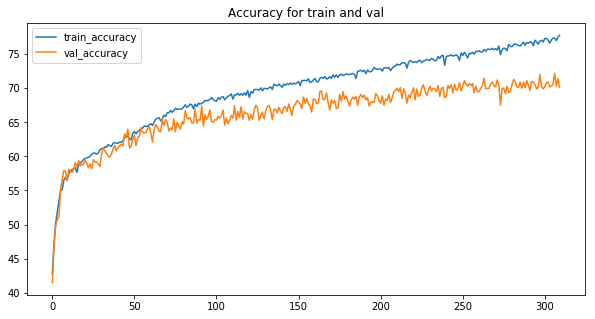

In [32]:
print('hidden_size_con = 300\n---------------------')
model = RNN(emb_size=300,hidden_size=300, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0, save=True)

### Hidden size for RNN = 300

Weight Decay = 0.0005
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 34.508, Validation Acc: 33.3
Epoch: [1/10], Step: [201/3125], Train Acc: 45.822, Validation Acc: 46.0
Epoch: [1/10], Step: [301/3125], Train Acc: 46.083, Validation Acc: 44.3
Epoch: [1/10], Step: [401/3125], Train Acc: 51.762, Validation Acc: 51.1
Epoch: [1/10], Step: [501/3125], Train Acc: 52.975, Validation Acc: 54.6
Epoch: [1/10], Step: [601/3125], Train Acc: 54.018, Validation Acc: 54.3
Epoch: [1/10], Step: [701/3125], Train Acc: 54.012, Validation Acc: 52.4
Epoch: [1/10], Step: [801/3125], Train Acc: 54.611, Validation Acc: 53.6
Epoch: [1/10], Step: [901/3125], Train Acc: 55.733, Validation Acc: 57.3
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.327, Validation Acc: 56.7
Epoch: [1/10], Step: [1101/3125], Train Acc: 55.996, Validation Acc: 57.0
Epoch: [1/10], Step: [1201/3125], Train Acc: 56.584, Validation Acc: 58.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.104, Validation Acc: 56.9
Epo

Epoch: [4/10], Step: [1901/3125], Train Acc: 61.252, Validation Acc: 60.6
Epoch: [4/10], Step: [2001/3125], Train Acc: 61.646, Validation Acc: 61.7
Epoch: [4/10], Step: [2101/3125], Train Acc: 62.199, Validation Acc: 61.3
Epoch: [4/10], Step: [2201/3125], Train Acc: 62.316, Validation Acc: 62.5
Epoch: [4/10], Step: [2301/3125], Train Acc: 62.112, Validation Acc: 61.5
Epoch: [4/10], Step: [2401/3125], Train Acc: 62.079, Validation Acc: 61.0
Epoch: [4/10], Step: [2501/3125], Train Acc: 62.223, Validation Acc: 62.0
Epoch: [4/10], Step: [2601/3125], Train Acc: 60.863, Validation Acc: 60.4
Epoch: [4/10], Step: [2701/3125], Train Acc: 62.523, Validation Acc: 60.9
Epoch: [4/10], Step: [2801/3125], Train Acc: 62.513, Validation Acc: 62.7
Epoch: [4/10], Step: [2901/3125], Train Acc: 62.353, Validation Acc: 61.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 62.627, Validation Acc: 62.6
Epoch: [4/10], Step: [3101/3125], Train Acc: 62.57, Validation Acc: 63.9
Epoch: [5/10], Step: [101/3125], Train 

Epoch: [8/10], Step: [701/3125], Train Acc: 65.404, Validation Acc: 65.4
Epoch: [8/10], Step: [801/3125], Train Acc: 65.87, Validation Acc: 64.1
Epoch: [8/10], Step: [901/3125], Train Acc: 65.869, Validation Acc: 64.9
Epoch: [8/10], Step: [1001/3125], Train Acc: 65.829, Validation Acc: 65.6
Epoch: [8/10], Step: [1101/3125], Train Acc: 66.08, Validation Acc: 65.8
Epoch: [8/10], Step: [1201/3125], Train Acc: 65.476, Validation Acc: 65.1
Epoch: [8/10], Step: [1301/3125], Train Acc: 65.502, Validation Acc: 65.2
Epoch: [8/10], Step: [1401/3125], Train Acc: 65.416, Validation Acc: 65.0
Epoch: [8/10], Step: [1501/3125], Train Acc: 65.84, Validation Acc: 65.6
Epoch: [8/10], Step: [1601/3125], Train Acc: 65.532, Validation Acc: 66.3
Epoch: [8/10], Step: [1701/3125], Train Acc: 65.99, Validation Acc: 65.0
Epoch: [8/10], Step: [1801/3125], Train Acc: 65.824, Validation Acc: 65.7
Epoch: [8/10], Step: [1901/3125], Train Acc: 65.907, Validation Acc: 65.4
Epoch: [8/10], Step: [2001/3125], Train Acc: 

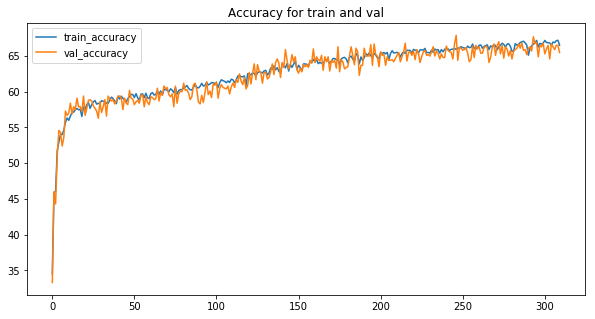

In [33]:
print('Weight Decay = 0.0005\n---------------------')
model = RNN(emb_size=300,hidden_size=300, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0.0005,save=False)

Weight Decay = 0.0001
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.775, Validation Acc: 33.2
Epoch: [1/10], Step: [201/3125], Train Acc: 46.385, Validation Acc: 46.5
Epoch: [1/10], Step: [301/3125], Train Acc: 50.102, Validation Acc: 48.3
Epoch: [1/10], Step: [401/3125], Train Acc: 52.673, Validation Acc: 53.4
Epoch: [1/10], Step: [501/3125], Train Acc: 54.351, Validation Acc: 53.9
Epoch: [1/10], Step: [601/3125], Train Acc: 54.975, Validation Acc: 55.6
Epoch: [1/10], Step: [701/3125], Train Acc: 55.682, Validation Acc: 55.6
Epoch: [1/10], Step: [801/3125], Train Acc: 56.161, Validation Acc: 56.3
Epoch: [1/10], Step: [901/3125], Train Acc: 56.656, Validation Acc: 55.6
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.762, Validation Acc: 56.9
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.369, Validation Acc: 57.4
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.71, Validation Acc: 56.8
Epoch: [1/10], Step: [1301/3125], Train Acc: 56.586, Validation Acc: 58.2
Epoc

Epoch: [4/10], Step: [1901/3125], Train Acc: 66.832, Validation Acc: 66.1
Epoch: [4/10], Step: [2001/3125], Train Acc: 66.676, Validation Acc: 65.3
Epoch: [4/10], Step: [2101/3125], Train Acc: 66.914, Validation Acc: 66.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 67.103, Validation Acc: 66.0
Epoch: [4/10], Step: [2301/3125], Train Acc: 66.582, Validation Acc: 66.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 66.352, Validation Acc: 65.2
Epoch: [4/10], Step: [2501/3125], Train Acc: 67.074, Validation Acc: 66.6
Epoch: [4/10], Step: [2601/3125], Train Acc: 66.924, Validation Acc: 65.9
Epoch: [4/10], Step: [2701/3125], Train Acc: 67.434, Validation Acc: 66.8
Epoch: [4/10], Step: [2801/3125], Train Acc: 67.065, Validation Acc: 65.4
Epoch: [4/10], Step: [2901/3125], Train Acc: 67.1, Validation Acc: 66.3
Epoch: [4/10], Step: [3001/3125], Train Acc: 67.056, Validation Acc: 66.3
Epoch: [4/10], Step: [3101/3125], Train Acc: 67.053, Validation Acc: 65.9
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 69.394, Validation Acc: 68.0
Epoch: [8/10], Step: [801/3125], Train Acc: 69.62, Validation Acc: 66.8
Epoch: [8/10], Step: [901/3125], Train Acc: 69.852, Validation Acc: 67.7
Epoch: [8/10], Step: [1001/3125], Train Acc: 69.955, Validation Acc: 67.7
Epoch: [8/10], Step: [1101/3125], Train Acc: 69.499, Validation Acc: 66.3
Epoch: [8/10], Step: [1201/3125], Train Acc: 69.839, Validation Acc: 67.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 69.131, Validation Acc: 64.1
Epoch: [8/10], Step: [1401/3125], Train Acc: 69.913, Validation Acc: 67.4
Epoch: [8/10], Step: [1501/3125], Train Acc: 69.676, Validation Acc: 66.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 70.178, Validation Acc: 67.9
Epoch: [8/10], Step: [1701/3125], Train Acc: 69.987, Validation Acc: 67.5
Epoch: [8/10], Step: [1801/3125], Train Acc: 69.778, Validation Acc: 66.3
Epoch: [8/10], Step: [1901/3125], Train Acc: 70.088, Validation Acc: 68.3
Epoch: [8/10], Step: [2001/3125], Train Ac

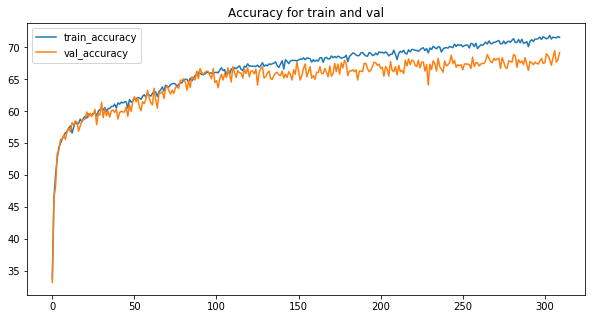

In [68]:
print('Weight Decay = 0.0001\n---------------------')
model = RNN(emb_size=300,hidden_size=300, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0.0001,save=False)

hidden_size_con = 300
---------------------
Epoch: [1/10], Step: [101/3125], Train Acc: 33.647, Validation Acc: 33.1
Epoch: [1/10], Step: [201/3125], Train Acc: 48.62, Validation Acc: 49.3
Epoch: [1/10], Step: [301/3125], Train Acc: 51.265, Validation Acc: 53.1
Epoch: [1/10], Step: [401/3125], Train Acc: 53.518, Validation Acc: 55.3
Epoch: [1/10], Step: [501/3125], Train Acc: 54.277, Validation Acc: 52.7
Epoch: [1/10], Step: [601/3125], Train Acc: 55.161, Validation Acc: 55.7
Epoch: [1/10], Step: [701/3125], Train Acc: 55.565, Validation Acc: 54.6
Epoch: [1/10], Step: [801/3125], Train Acc: 56.68, Validation Acc: 57.4
Epoch: [1/10], Step: [901/3125], Train Acc: 56.787, Validation Acc: 57.2
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.88, Validation Acc: 57.8
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.556, Validation Acc: 57.3
Epoch: [1/10], Step: [1201/3125], Train Acc: 57.57, Validation Acc: 59.8
Epoch: [1/10], Step: [1301/3125], Train Acc: 58.053, Validation Acc: 59.1
Epoch: 

Epoch: [4/10], Step: [1901/3125], Train Acc: 69.301, Validation Acc: 65.3
Epoch: [4/10], Step: [2001/3125], Train Acc: 69.136, Validation Acc: 65.6
Epoch: [4/10], Step: [2101/3125], Train Acc: 68.604, Validation Acc: 65.4
Epoch: [4/10], Step: [2201/3125], Train Acc: 68.864, Validation Acc: 66.0
Epoch: [4/10], Step: [2301/3125], Train Acc: 69.37, Validation Acc: 66.0
Epoch: [4/10], Step: [2401/3125], Train Acc: 69.081, Validation Acc: 66.8
Epoch: [4/10], Step: [2501/3125], Train Acc: 69.393, Validation Acc: 66.4
Epoch: [4/10], Step: [2601/3125], Train Acc: 69.372, Validation Acc: 66.9
Epoch: [4/10], Step: [2701/3125], Train Acc: 69.505, Validation Acc: 67.2
Epoch: [4/10], Step: [2801/3125], Train Acc: 69.291, Validation Acc: 68.3
Epoch: [4/10], Step: [2901/3125], Train Acc: 69.704, Validation Acc: 67.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 69.89, Validation Acc: 67.5
Epoch: [4/10], Step: [3101/3125], Train Acc: 69.512, Validation Acc: 66.6
Epoch: [5/10], Step: [101/3125], Train A

Epoch: [8/10], Step: [701/3125], Train Acc: 74.16, Validation Acc: 69.9
Epoch: [8/10], Step: [801/3125], Train Acc: 74.057, Validation Acc: 70.4
Epoch: [8/10], Step: [901/3125], Train Acc: 74.293, Validation Acc: 69.7
Epoch: [8/10], Step: [1001/3125], Train Acc: 74.188, Validation Acc: 70.4
Epoch: [8/10], Step: [1101/3125], Train Acc: 74.488, Validation Acc: 69.1
Epoch: [8/10], Step: [1201/3125], Train Acc: 74.365, Validation Acc: 70.3
Epoch: [8/10], Step: [1301/3125], Train Acc: 74.374, Validation Acc: 70.1
Epoch: [8/10], Step: [1401/3125], Train Acc: 74.341, Validation Acc: 69.4
Epoch: [8/10], Step: [1501/3125], Train Acc: 74.687, Validation Acc: 70.1
Epoch: [8/10], Step: [1601/3125], Train Acc: 74.748, Validation Acc: 68.8
Epoch: [8/10], Step: [1701/3125], Train Acc: 74.539, Validation Acc: 68.8
Epoch: [8/10], Step: [1801/3125], Train Acc: 74.784, Validation Acc: 70.4
Epoch: [8/10], Step: [1901/3125], Train Acc: 74.938, Validation Acc: 69.8
Epoch: [8/10], Step: [2001/3125], Train Ac

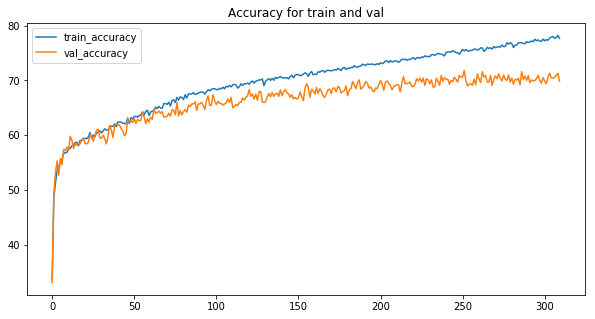

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
print('hidden_size_con = 300\n---------------------')
model = RNN(emb_size=300,hidden_size=300, hidden_size_ln = 50, num_layers=1, num_classes=3, vocab_size=len(id2token))
train_model(model, lr = 3e-4, nepochs = 10, decay = 0, save=True)

# MNLI

In [36]:
train_Mnli = pd.read_csv('mnli_train.tsv',sep='\t')
val_Mnli = pd.read_csv('mnli_val.tsv',sep='\t')

In [37]:
print(train_Mnli.shape,val_Mnli.shape)
print(train_Mnli.columns)
print(set(train_Mnli['genre']))

(20000, 4) (5000, 4)
Index(['sentence1', 'sentence2', 'label', 'genre'], dtype='object')
{'telephone', 'government', 'slate', 'fiction', 'travel'}


In [43]:
# split the sentence
def handlesentence(colname,dataset):
    temp = []
    for i in dataset[colname].tolist():
        temp.append(i.split(' '))
    dataset[colname + '_split'] = temp

handlesentence('sentence1',train_Mnli)
handlesentence('sentence2',train_Mnli)
handlesentence('sentence1',val_Mnli)
handlesentence('sentence2',val_Mnli) 

# Assign -1, 0, 1 to contradiction, neutral and entailment
conditions_tr = [train_Mnli['label'] == 'neutral',train_Mnli['label'] == 'entailment', train_Mnli['label'] == 'contradiction']
conditions_val = [val_Mnli['label'] == 'neutral',val_Mnli['label'] == 'entailment', val_Mnli['label'] == 'contradiction']
choices = [0,1,2]
train_Mnli['label_class'] = np.select(conditions_tr, choices)
val_Mnli['label_class'] = np.select(conditions_val, choices)

#train_travel = train.loc[train['genre'] == 'travel']

In [52]:
# split the dataset based on the genre
def handledataset(dataset,genre): 
    newdataset = dataset.loc[dataset['genre'] == genre]
    newdataset_X = newdataset.iloc[:,[5,6]]
    newdataset_y = newdataset.iloc[:,4]
    return newdataset, newdataset_X, newdataset_y

In [67]:
voc_size = 50000
PAD_IDX = 0
UNK_IDX = 1
num_epochs=10
MAX_SENTENCE_LENGTH = 300
BATCH_SIZE = 32

In [62]:
id2token = pkl.load(open("id2token.p","rb"))
token2id = pkl.load(open("token2id.p","rb"))
emb_vec = pkl.load(open("emb_vec.p","rb"))

In [63]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [75]:
model_CNN = torch.load('BestModel_CNN.pth')

In [76]:
model_RNN = torch.load('BestModel_RNN.pth')

In [77]:
model_CNN

CNN(
  (embedding): Embedding(50002, 300)
  (conv1): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(150, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear1): Linear(in_features=300, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)

In [78]:
model_RNN

RNN(
  (embedding): Embedding(50002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=1200, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)

## Travel

In [53]:
train_travel, train_travel_X, train_travel_y = handledataset(train_Mnli,'travel')
val_travel, val_travel_X, val_travel_y = handledataset(val_Mnli,'travel')

In [59]:
print(train_travel_X.shape,train_travel_y.shape)
print(val_travel_X.shape,val_travel_y.shape)

(3985, 2) (3985,)
(982, 2) (982,)


In [60]:
train_X_travel_s1 = []
train_X_travel_s2 = []
val_X_travel_s1 = []
val_X_travel_s2 = []
        
for i in train_travel_X.loc[:,'sentence1_split']:
    train_X_travel_s1.append(i)
for j in train_travel_X.loc[:,'sentence2_split']:
    train_X_travel_s2.append(j)
for m in val_travel_X.loc[:,'sentence1_split']:
    val_X_travel_s1.append(m)
for n in val_travel_X.loc[:,'sentence2_split']:
    val_X_travel_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_travel_s1))
print('Length of train_X_s2: ', len(train_X_travel_s2))
print('Length of val_X_s1: ', len(val_X_travel_s1))
print('Length of val_X_s2: ', len(val_X_travel_s2))

Length of train_X_s1:  3985
Length of train_X_s2:  3985
Length of val_X_s1:  982
Length of val_X_s2:  982


In [64]:
train_data_indices_travel_s1 = token2index_dataset(train_X_travel_s1)
train_data_indices_travel_s2 = token2index_dataset(train_X_travel_s2)
val_data_indices_travel_s1 = token2index_dataset(val_X_travel_s1)
val_data_indices_travel_s2 = token2index_dataset(val_X_travel_s2)

In [79]:
train_targets = np.asarray(train_travel_y)
val_targets = np.asarray(val_travel_y)

train_travel_dataset = SNLI_Dataset(train_data_indices_travel_s1, train_data_indices_travel_s2, train_targets)
train_travel_loader = torch.utils.data.DataLoader(dataset=train_travel_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_travel_dataset = SNLI_Dataset(val_data_indices_travel_s1, val_data_indices_travel_s2, val_targets)
val_travel_loader = torch.utils.data.DataLoader(dataset=val_travel_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [86]:
# Validate
val_travel_acc_CNN = test_model(val_travel_loader,model_CNN)
val_travel_acc_RNN = test_model(val_travel_loader,model_RNN)

print('Validation Acc (Best CNN Model): {}'.format(val_travel_acc_CNN))
print('Validation Acc (Best RNN Model): {}'.format(val_travel_acc_RNN))

Validation Acc (Best CNN Model): 43.9918533604888
Validation Acc (Best RNN Model): 47.657841140529534


## Slate

In [87]:
train_slate, train_slate_X, train_slate_y = handledataset(train_Mnli,'slate')
val_slate, val_slate_X, val_slate_y = handledataset(val_Mnli,'slate')

In [88]:
train_X_slate_s1 = []
train_X_slate_s2 = []
val_X_slate_s1 = []
val_X_slate_s2 = []
        
for i in train_slate_X.loc[:,'sentence1_split']:
    train_X_slate_s1.append(i)
for j in train_slate_X.loc[:,'sentence2_split']:
    train_X_slate_s2.append(j)
for m in val_slate_X.loc[:,'sentence1_split']:
    val_X_slate_s1.append(m)
for n in val_slate_X.loc[:,'sentence2_split']:
    val_X_slate_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_slate_s1))
print('Length of train_X_s2: ', len(train_X_slate_s2))
print('Length of val_X_s1: ', len(val_X_slate_s1))
print('Length of val_X_s2: ', len(val_X_slate_s2))

Length of train_X_s1:  4026
Length of train_X_s2:  4026
Length of val_X_s1:  1002
Length of val_X_s2:  1002


In [89]:
train_data_indices_slate_s1 = token2index_dataset(train_X_slate_s1)
train_data_indices_slate_s2 = token2index_dataset(train_X_slate_s2)
val_data_indices_slate_s1 = token2index_dataset(val_X_slate_s1)
val_data_indices_slate_s2 = token2index_dataset(val_X_slate_s2)

In [92]:
train_targets = np.asarray(train_slate_y)
val_targets = np.asarray(val_slate_y)

train_slate_dataset = SNLI_Dataset(train_data_indices_slate_s1, train_data_indices_slate_s2, train_targets)
train_slate_loader = torch.utils.data.DataLoader(dataset=train_slate_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_slate_dataset = SNLI_Dataset(val_data_indices_slate_s1, val_data_indices_slate_s2, val_targets)
val_slate_loader = torch.utils.data.DataLoader(dataset=val_slate_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [93]:
# Validate
val_slate_acc_CNN = test_model(val_slate_loader,model_CNN)
val_slate_acc_RNN = test_model(val_slate_loader,model_RNN)

print('Validation Acc (Best CNN Model): {}'.format(val_slate_acc_CNN))
print('Validation Acc (Best RNN Model): {}'.format(val_slate_acc_RNN))

Validation Acc (Best CNN Model): 40.7185628742515
Validation Acc (Best RNN Model): 45.30938123752495


## Telephone

In [94]:
train_tele, train_tele_X, train_tele_y = handledataset(train_Mnli,'telephone')
val_tele, val_tele_X, val_tele_y = handledataset(val_Mnli,'telephone')

In [95]:
train_X_tele_s1 = []
train_X_tele_s2 = []
val_X_tele_s1 = []
val_X_tele_s2 = []
        
for i in train_tele_X.loc[:,'sentence1_split']:
    train_X_tele_s1.append(i)
for j in train_tele_X.loc[:,'sentence2_split']:
    train_X_tele_s2.append(j)
for m in val_tele_X.loc[:,'sentence1_split']:
    val_X_tele_s1.append(m)
for n in val_tele_X.loc[:,'sentence2_split']:
    val_X_tele_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_tele_s1))
print('Length of train_X_s2: ', len(train_X_tele_s2))
print('Length of val_X_s1: ', len(val_X_tele_s1))
print('Length of val_X_s2: ', len(val_X_tele_s2))

Length of train_X_s1:  4270
Length of train_X_s2:  4270
Length of val_X_s1:  1005
Length of val_X_s2:  1005


In [110]:
train_data_indices_tele_s1 = token2index_dataset(train_X_tele_s1)
train_data_indices_tele_s2 = token2index_dataset(train_X_tele_s2)
val_data_indices_tele_s1 = token2index_dataset(val_X_tele_s1)
val_data_indices_tele_s2 = token2index_dataset(val_X_tele_s2)

In [97]:
train_targets = np.asarray(train_tele_y)
val_targets = np.asarray(val_tele_y)

train_tele_dataset = SNLI_Dataset(train_data_indices_tele_s1, train_data_indices_tele_s2, train_targets)
train_tele_loader = torch.utils.data.DataLoader(dataset=train_tele_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_tele_dataset = SNLI_Dataset(val_data_indices_tele_s1, val_data_indices_tele_s2, val_targets)
val_tele_loader = torch.utils.data.DataLoader(dataset=val_tele_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [99]:
# Validate
val_tele_acc_CNN = test_model(val_tele_loader,model_CNN)
val_tele_acc_RNN = test_model(val_tele_loader,model_RNN)

print('Validation Acc (Best CNN Model): {}'.format(val_tele_acc_CNN))
print('Validation Acc (Best RNN Model): {}'.format(val_tele_acc_RNN))

Validation Acc (Best CNN Model): 42.08955223880597
Validation Acc (Best RNN Model): 46.46766169154229


## Fiction

In [100]:
train_fic, train_fic_X, train_fic_y = handledataset(train_Mnli,'fiction')
val_fic, val_fic_X, val_fic_y = handledataset(val_Mnli,'fiction')

In [101]:
train_X_fic_s1 = []
train_X_fic_s2 = []
val_X_fic_s1 = []
val_X_fic_s2 = []
        
for i in train_fic_X.loc[:,'sentence1_split']:
    train_X_fic_s1.append(i)
for j in train_fic_X.loc[:,'sentence2_split']:
    train_X_fic_s2.append(j)
for m in val_fic_X.loc[:,'sentence1_split']:
    val_X_fic_s1.append(m)
for n in val_fic_X.loc[:,'sentence2_split']:
    val_X_fic_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_fic_s1))
print('Length of train_X_s2: ', len(train_X_fic_s2))
print('Length of val_X_s1: ', len(val_X_fic_s1))
print('Length of val_X_s2: ', len(val_X_fic_s2))

Length of train_X_s1:  3836
Length of train_X_s2:  3836
Length of val_X_s1:  995
Length of val_X_s2:  995


In [102]:
train_data_indices_fic_s1 = token2index_dataset(train_X_fic_s1)
train_data_indices_fic_s2 = token2index_dataset(train_X_fic_s2)
val_data_indices_fic_s1 = token2index_dataset(val_X_fic_s1)
val_data_indices_fic_s2 = token2index_dataset(val_X_fic_s2)

In [103]:
train_targets = np.asarray(train_fic_y)
val_targets = np.asarray(val_fic_y)

train_fic_dataset = SNLI_Dataset(train_data_indices_fic_s1, train_data_indices_fic_s2, train_targets)
train_fic_loader = torch.utils.data.DataLoader(dataset=train_fic_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_fic_dataset = SNLI_Dataset(val_data_indices_fic_s1, val_data_indices_fic_s2, val_targets)
val_fic_loader = torch.utils.data.DataLoader(dataset=val_fic_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [105]:
# Validate
val_fic_acc_CNN = test_model(val_fic_loader,model_CNN)
val_fic_acc_RNN = test_model(val_fic_loader,model_RNN)

print('Validation Acc (Best CNN Model): {}'.format(val_fic_acc_CNN))
print('Validation Acc (Best RNN Model): {}'.format(val_fic_acc_RNN))

Validation Acc (Best CNN Model): 42.11055276381909
Validation Acc (Best RNN Model): 51.65829145728643


## Government

In [122]:
train_gov, train_gov_X, train_gov_y = handledataset(train_Mnli,'government')
val_gov, val_gov_X, val_gov_y = handledataset(val_Mnli,'government')

In [136]:
val_gov_X.shape

(1016, 2)

In [137]:
train_X_gov_s1 = []
train_X_gov_s2 = []
val_X_gov_s1 = []
val_X_gov_s2 = []
        
for i in train_gov_X.loc[:,'sentence1_split']:
    train_X_gov_s1.append(i)
for j in train_gov_X.loc[:,'sentence2_split']:
    train_X_gov_s2.append(j)
for m in val_gov_X.loc[:,'sentence1_split']:
    val_X_gov_s1.append(m)
for n in val_gov_X.loc[:,'sentence2_split']:
    val_X_gov_s2.append(n)
    
print('Length of train_X_s1: ', len(train_X_gov_s1))
print('Length of train_X_s2: ', len(train_X_gov_s2))
print('Length of val_X_s1: ', len(val_X_gov_s1))
print('Length of val_X_s2: ', len(val_X_gov_s2))

Length of train_X_s1:  3883
Length of train_X_s2:  3883
Length of val_X_s1:  1016
Length of val_X_s2:  1016


In [138]:
train_data_indices_gov_s1 = token2index_dataset(train_X_gov_s1)
train_data_indices_gov_s2 = token2index_dataset(train_X_gov_s2)
val_data_indices_gov_s1 = token2index_dataset(val_X_gov_s1)
val_data_indices_gov_s2 = token2index_dataset(val_X_gov_s2)

In [140]:
train_targets = np.asarray(train_gov_y)
val_targets = np.asarray(val_gov_y)

train_gov_dataset = SNLI_Dataset(train_data_indices_gov_s1, train_data_indices_gov_s2, train_targets)
train_gov_loader = torch.utils.data.DataLoader(dataset=train_gov_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_gov_dataset = SNLI_Dataset(val_data_indices_gov_s1, val_data_indices_gov_s2, val_targets)
val_gov_loader = torch.utils.data.DataLoader(dataset=val_gov_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [141]:
# Validate
val_gov_acc_CNN = test_model(val_gov_loader,model_CNN)
val_gov_acc_RNN = test_model(val_gov_loader,model_RNN)

print('Validation Acc (Best CNN Model): {}'.format(val_gov_acc_CNN))
print('Validation Acc (Best RNN Model): {}'.format(val_gov_acc_RNN))

Validation Acc (Best CNN Model): 44.29133858267716
Validation Acc (Best RNN Model): 47.145669291338585


## Fine-tuning (RNN model)

In [153]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    model.eval()
    for s1, lens1, s2, lens2, labels in loader:
        
        data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2,label_batch = s1.to(device), lens1.to(device), \
        s2.to(device), lens2.to(device), labels.to(device)
        outputs1 = model(data_batch_1, lengths_batch_1, data_batch_2, lengths_batch_2)
        outputs = F.softmax(outputs1,dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def fine_tune(model,lr,nepochs,decay,trainloader,valloader,genre):
    model = model.to(device)
    learning_rate = lr
    num_epochs = nepochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay)

    # Train the model
    total_step = len(trainloader)

    val_acclst = []
    train_acclst = []
    train_acc = 0
    val_acc = 0

    for epoch in range(num_epochs):
        for i, (s1, lens1, s2, lens2, labels) in enumerate(trainloader): 
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(s1.to(device), lens1.to(device), s2.to(device), lens2.to(device))
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
#                 validate

                train_acc = test_model(trainloader, model)
                train_acclst.append(train_acc)

                val_acc = test_model(valloader, model)
                val_acclst.append(val_acc)

                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                    epoch+1, num_epochs, i+1, len(trainloader), train_acc, val_acc))


    plt.figure(figsize=(10,5))
    plt.plot(train_acclst,label='train_accuracy')
    plt.plot(val_acclst,label='val_accuracy')
    plt.title('Accuracy for train and val')
    plt.legend()
    plt.show()
    
    torch.save(model,str(genre)+'.pth')

    


## Travel

Train on Travel Genre
---------------------
Epoch: [1/5], Step: [101/125], Train Acc: 54.30363864491844, Validation Acc: 51.73116089613035
Epoch: [2/5], Step: [101/125], Train Acc: 59.37264742785445, Validation Acc: 54.68431771894094
Epoch: [3/5], Step: [101/125], Train Acc: 62.30865746549561, Validation Acc: 52.54582484725051
Epoch: [4/5], Step: [101/125], Train Acc: 66.64993726474279, Validation Acc: 56.313645621181266
Epoch: [5/5], Step: [101/125], Train Acc: 70.56461731493098, Validation Acc: 56.109979633401224


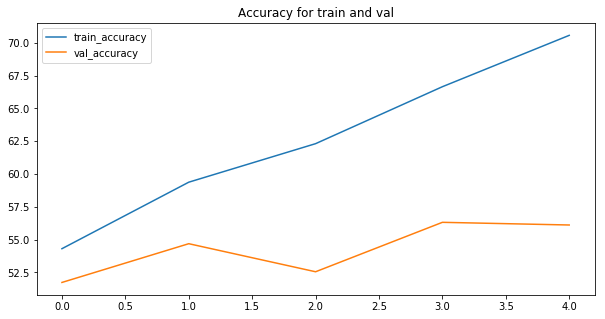

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [156]:
print('Train on Travel Genre\n---------------------')
model_RNN = torch.load('BestModel_RNN.pth')
fine_tune(model_RNN, lr = 3e-4, nepochs = 5, decay = 0, 
          trainloader = train_travel_loader, valloader = val_travel_loader,genre = 'travel')

## Slate

Train on Slate Genre
---------------------
Epoch: [1/5], Step: [101/126], Train Acc: 47.46646795827124, Validation Acc: 43.712574850299404
Epoch: [2/5], Step: [101/126], Train Acc: 52.7819175360159, Validation Acc: 46.40718562874252
Epoch: [3/5], Step: [101/126], Train Acc: 58.27123695976155, Validation Acc: 46.8063872255489
Epoch: [4/5], Step: [101/126], Train Acc: 60.60606060606061, Validation Acc: 47.0059880239521
Epoch: [5/5], Step: [101/126], Train Acc: 64.82861400894188, Validation Acc: 46.706586826347305


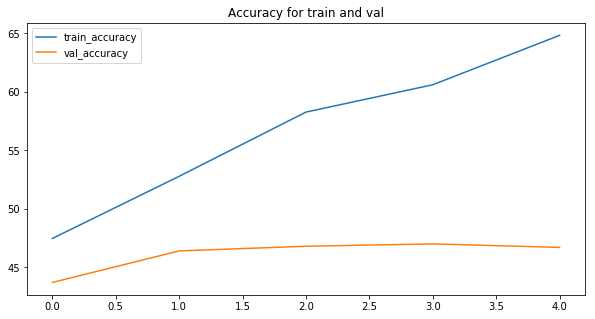

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [157]:
print('Train on Slate Genre\n---------------------')
model_RNN = torch.load('BestModel_RNN.pth')
fine_tune(model_RNN, lr = 3e-4, nepochs = 5, decay = 0, 
          trainloader = train_slate_loader, valloader = val_slate_loader,genre = 'slate')

## Telephone

Train on Telephone Genre
---------------------
Epoch: [1/5], Step: [101/134], Train Acc: 52.34192037470726, Validation Acc: 50.54726368159204
Epoch: [2/5], Step: [101/134], Train Acc: 55.15222482435597, Validation Acc: 52.33830845771144
Epoch: [3/5], Step: [101/134], Train Acc: 58.40749414519906, Validation Acc: 54.22885572139303
Epoch: [4/5], Step: [101/134], Train Acc: 61.80327868852459, Validation Acc: 52.039800995024876
Epoch: [5/5], Step: [101/134], Train Acc: 65.31615925058549, Validation Acc: 54.22885572139303


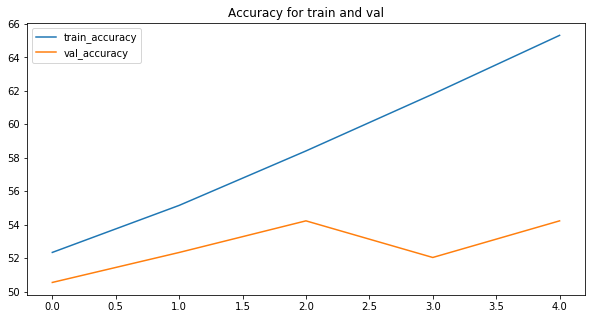

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [158]:
print('Train on Telephone Genre\n---------------------')
model_RNN = torch.load('BestModel_RNN.pth')
fine_tune(model_RNN, lr = 3e-4, nepochs = 5, decay = 0, 
          trainloader = train_tele_loader, valloader = val_tele_loader,genre = 'telephone')

## Fiction

Train on Fiction Genre
---------------------
Epoch: [1/5], Step: [101/120], Train Acc: 54.718456725756, Validation Acc: 51.256281407035175
Epoch: [2/5], Step: [101/120], Train Acc: 58.315954118873826, Validation Acc: 52.663316582914575
Epoch: [3/5], Step: [101/120], Train Acc: 62.40875912408759, Validation Acc: 54.87437185929648
Epoch: [4/5], Step: [101/120], Train Acc: 65.58915537017727, Validation Acc: 55.37688442211055
Epoch: [5/5], Step: [101/120], Train Acc: 70.38581856100105, Validation Acc: 56.482412060301506


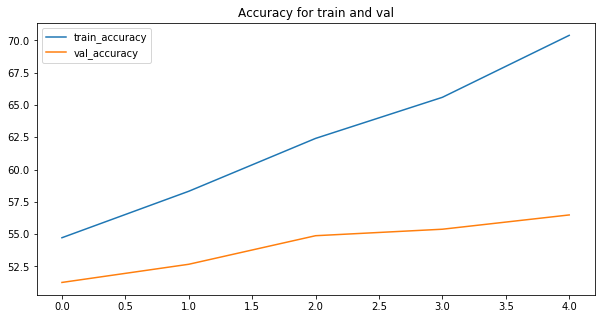

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [159]:
print('Train on Fiction Genre\n---------------------')
model_RNN = torch.load('BestModel_RNN.pth')
fine_tune(model_RNN, lr = 3e-4, nepochs = 5, decay = 0, 
          trainloader = train_fic_loader, valloader = val_fic_loader,genre = 'fiction')

## Government

Train on Government Genre
---------------------
Epoch: [1/5], Step: [101/122], Train Acc: 54.5712078289982, Validation Acc: 54.625984251968504
Epoch: [2/5], Step: [101/122], Train Acc: 58.82049961370075, Validation Acc: 55.610236220472444
Epoch: [3/5], Step: [101/122], Train Acc: 62.60623229461756, Validation Acc: 56.79133858267716
Epoch: [4/5], Step: [101/122], Train Acc: 66.18593870718517, Validation Acc: 56.69291338582677
Epoch: [5/5], Step: [101/122], Train Acc: 69.17331959824878, Validation Acc: 56.10236220472441


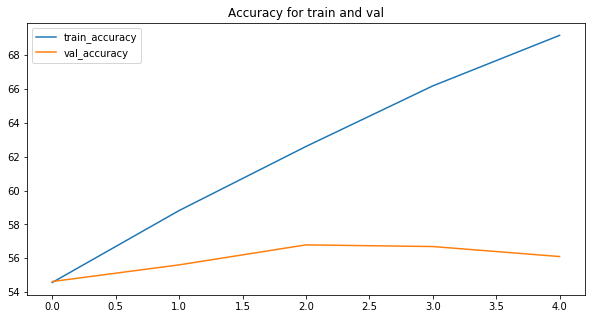

/home/leo/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [160]:
print('Train on Government Genre\n---------------------')
model_RNN = torch.load('BestModel_RNN.pth')
fine_tune(model_RNN, lr = 3e-4, nepochs = 5, decay = 0, 
          trainloader = train_gov_loader, valloader = val_gov_loader,genre = 'government')

## Evaluate each fine-tuned model on every other genre

### Travel model

In [161]:
travel_model = torch.load('travel.pth')

In [165]:
# Validate
val_travel_on_slate = test_model(val_slate_loader,travel_model)
val_travel_on_tele = test_model(val_tele_loader,travel_model)
val_travel_on_fic = test_model(val_fic_loader,travel_model)
val_travel_on_gov = test_model(val_gov_loader,travel_model)

print('Validation Acc (travel_on_slate): {}'.format(val_travel_on_slate))
print('Validation Acc (travel_on_tele): {}'.format(val_travel_on_tele))
print('Validation Acc (travel_on_fic): {}'.format(val_travel_on_fic))
print('Validation Acc (travel_on_gov): {}'.format(val_travel_on_gov))

Validation Acc (travel_on_slate): 46.60678642714571
Validation Acc (travel_on_tele): 49.65174129353234
Validation Acc (travel_on_fic): 51.959798994974875
Validation Acc (travel_on_gov): 53.74015748031496


### Slate model

In [166]:
slate_model = torch.load('slate.pth')

In [167]:
# Validate
val_slate_on_travel = test_model(val_travel_loader,slate_model)
val_slate_on_tele = test_model(val_tele_loader,slate_model)
val_slate_on_fic = test_model(val_fic_loader,slate_model)
val_slate_on_gov = test_model(val_gov_loader,slate_model)

print('Validation Acc (slate_on_slate): {}'.format(val_slate_on_travel))
print('Validation Acc (slate_on_tele): {}'.format(val_slate_on_tele))
print('Validation Acc (slate_on_fic): {}'.format(val_slate_on_fic))
print('Validation Acc (slate_on_gov): {}'.format(val_slate_on_gov))

Validation Acc (slate_on_slate): 52.342158859470466
Validation Acc (slate_on_tele): 52.23880597014925
Validation Acc (slate_on_fic): 52.462311557788944
Validation Acc (slate_on_gov): 55.80708661417323


### Telephone model

In [168]:
telephone_model = torch.load('telephone.pth')

In [169]:
# Validate
val_telephone_on_travel = test_model(val_travel_loader,telephone_model)
val_telephone_on_slate = test_model(val_slate_loader,telephone_model)
val_telephone_on_fic = test_model(val_fic_loader,telephone_model)
val_telephone_on_gov = test_model(val_gov_loader,telephone_model)

print('Validation Acc (telephone_on_slate): {}'.format(val_telephone_on_travel))
print('Validation Acc (telephone_on_tele): {}'.format(val_telephone_on_slate))
print('Validation Acc (telephone_on_fic): {}'.format(val_telephone_on_fic))
print('Validation Acc (telephone_on_gov): {}'.format(val_telephone_on_gov))

Validation Acc (telephone_on_slate): 52.03665987780041
Validation Acc (telephone_on_tele): 47.80439121756487
Validation Acc (telephone_on_fic): 53.768844221105525
Validation Acc (telephone_on_gov): 52.95275590551181


### Fiction model

In [170]:
fiction_model = torch.load('fiction.pth')

In [171]:
# Validate
val_fiction_on_slate = test_model(val_slate_loader,fiction_model)
val_fiction_on_tele = test_model(val_tele_loader,fiction_model)
val_fiction_on_travel = test_model(val_travel_loader,fiction_model)
val_fiction_on_gov = test_model(val_gov_loader,fiction_model)

print('Validation Acc (fiction_on_travel): {}'.format(val_fiction_on_travel))
print('Validation Acc (fiction_on_slate): {}'.format(val_fiction_on_slate))
print('Validation Acc (fiction_on_tele): {}'.format(val_fiction_on_tele))
print('Validation Acc (fiction_on_gov): {}'.format(val_fiction_on_gov))

Validation Acc (fiction_on_travel): 51.73116089613035
Validation Acc (fiction_on_slate): 47.80439121756487
Validation Acc (fiction_on_tele): 50.9452736318408
Validation Acc (fiction_on_gov): 53.05118110236221


### Government model

In [172]:
government_model = torch.load('government.pth')

In [173]:
# Validate
val_government_on_slate = test_model(val_slate_loader,government_model)
val_government_on_tele = test_model(val_tele_loader,government_model)
val_government_on_fic = test_model(val_fic_loader,government_model)
val_government_on_travel = test_model(val_travel_loader,government_model)

print('Validation Acc (government_on_travel): {}'.format(val_government_on_travel))
print('Validation Acc (government_on_slate): {}'.format(val_government_on_slate))
print('Validation Acc (government_on_tele): {}'.format(val_government_on_tele))
print('Validation Acc (government_on_fic): {}'.format(val_government_on_fic))


Validation Acc (government_on_travel): 52.85132382892057
Validation Acc (government_on_slate): 47.80439121756487
Validation Acc (government_on_tele): 47.66169154228856
Validation Acc (government_on_fic): 52.36180904522613
